
<a name="top"> <h1>3. FALSOS REEMPLAZOS - ISOLATION TREE</h1> <a>


<p>DECISION TREE - FALSOS REEMPLAZOS<br />
<strong>Price to Market Motor</strong><br />



<p style="text-align:right">Miguel D&iacute;az-Mauriño (<em>miguel.diaz@allianz.es</em>)</p>


# Setup notebooks

### General libraries

In [1]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import sys
import lightgbm as lgb
import re
import chardet

from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

### Logging

In [2]:
import logging

logging.basicConfig(format='%(asctime)s - %(message)s', level=logging.INFO)
logger = logging.getLogger(__name__)

### Load enviroment variables and adding to PYTHONPATH

In [3]:
from dotenv import load_dotenv
load_dotenv('.env')

code_root = os.environ['CODE_ROOT']
cfg_path = os.environ['CFG_PATH']
data_root = os.environ['DATA_ROOT']

sys.path.insert(0, code_root)

### Specific libraries

In [4]:
from src.utils import lgbm_feature_importance, decision_tree_model, label_encode_variables, plot_cramer, plot_lgb_importances, asignar_CCAA
# lgbm_feature_importance,
from src.load_functions import get_renames
from src.data_dict import formato, get_import_columns, get_dtypes_dict, get_rename_dict, get_features_model, get_features, get_feature_type, date_format

### Configuration dictionary

In [5]:
df = pd.read_parquet(os.path.join(data_root, 'FR_Tomador.parquet'))

df.head(5)

,POLIZA,APLICA,RAMO,prima_prop,PRIMA_ANT,PAQ_REPORTING,FRENOV,agrupacm,PRIMAN,MOTANUL,FANUL,FIANUL,CLASS_ANUL,Anulada,POLIZAN,APLICAN,CODPOST,POLIZAS_45,AGENTE,DC,SUCURSAL,USO,TOMADOR,TXCANAL,CODMEDP,CATTAG,AGRUPAGENTE,prima_reemplazante,prperiod,SINOCU,N_ANT,N_ACTUAL,Sdadpol_12M,DTO_DEFENSA,PRIMA_DEFENSA_ADPR,CORREDOR_PILOTO,sdad_total3p,sdad_total_tom,anualidad_seguro,Edad_conductor,APTP,rwCoeff_forced,retention,retention_def,Retencion_antes,TechPrice,num_stros_ultaño,num_stros_aga_ultaño,total_stros_ultaño,Valor_Mediador_Turismos,Prob_anul,CODMEDP_bnd,Prueba_Piloto_bnd,Super_rentables_bnd,Corredores_bnd,cltv_decile,Aleatorio,Segmentos_sept,segmento_deficiente_bnd,CAPTOTAL_vida,Edad_tomador_bnd,empleados,POL_VIDA,bm_anualidad,BM_cat,IsBMP,Random,Random_22,DEFENDIBLE,bm_ampliado,Stros2,CS,Provincia,m_anul,Sdadpol_12M_anterior,stros_anterior,defendida_SAS,defendida_ant,FR,priman_new_fr,POLIZAR,PAQUETE_REPORTING,paquete_reporting_reempl,polizar_post,tipo_reemplazo,FRFINAL,GARANTIA_1,GARANTIA_2,GARANTIA_3,GARANTIA_4,GARANTIA_5,GARANTIA_6,GARANTIA_7,GARANTIA_8,Gar_missing,MODALIDAD,SEX,ASISTENCIA,COND_TOM,COND_PROP,MATRICULA,CILIND,POTENCIA,CLASEVH,VALORVH,MARCA,MODELO,BASICO,ROBO,DANOS,FRANQUI,PAQUETE,PLAZAS,GRUA,NPROPIETARIO,ID_CLIENTE,FNACI8,FCARN8,FMATRI,ANTIG_VEHICULO,BNS_TIPO_CONSULTA,APR_new,TPR_new,APR_old,TPR_old,CANAL_Med,Nombre_Med,Mediador_Principal_Med,MEDIADOR_Med,solicitud_Med,coti_tec_Med,version_coti_Med,poli_Med,Reemplazo_Med,BM_ACTUAL_Med,BM_ACTUAL_pol_Med,Dto_aplicado_coti_Med,Dto_aplicado_poli_Med,tirea_NO_deseado_Med,FP_NO_Anual_Med,diferente_CP_Med,Dcto_coti_CAP_Med,Dcto_coti_VC_Med,Dcto_coti_TRA_Med,Dcto_coti_CAPVC_Med,Dcto_coti_VCTRA_Med,Dcto_poli_CAP_Med,Dcto_poli_VC_Med,Dcto_poli_TRA_Med,Dcto_poli_CAPVC_Med,Dcto_poli_VCTRA_Med,PRIANUALAC_Med,Canc_NB_Med,Canc_RW_Med,Canc_Impag_NB_Med,Canc_Impag_RW_Med,exp_Med,prima_ganada_Med,Sini_tot_Med,Coste_tot_Med,Sini_RC_Med,Coste_RC_Med,Sini_Danos_Med,Coste_Danos_Med,exp_Danos_Med,Desbloqueo_Med,Desbl_FalsoReemp_Med,Desbl_Menores_Med,DEFENDIDA_Med,DEFENDIBLE_Med,Ratio_DEFENSA_Med,Coste_defensa_Med,tot_MEDIADORES_Med,Ratio_Solicitud_Med,Ratio_Cotizacion_Med,Ratio_Reemplazo_Med,Ratio_BM_Med,Ratio_Tirea_No_deseado_Med,Ratio_Diferente_CP_Med,Ratio_Poli_CAP_Med,Ratio_Poli_VC_Med,Ratio_Poli_TRA_Med,Ratio_Canc_NB_Med,Ratio_Canc_RW_Med,Ratio_Canc_impag_NB_Med,Ratio_Canc_impag_RW_Med,Ratio_Coste_Defensa_Med,Ratio_Fracc_Med,Ratio_Desbloqueo_Med,Ratio_Desbl_FalsoReemp_Med,Ratio_Desbl_Menores_Med,desv_Solicitud_Med,desv_Cotizacion_Med,desv_Reemplazo_Med,desv_BM_Med,desv_Tirea_No_deseado_Med,desv_Diferente_CP_Med,desv_Poli_CAP_Med,desv_Poli_VC_Med,desv_Poli_TRA_Med,desv_Canc_NB_Med,desv_Canc_RW_Med,desv_Canc_impag_NB_Med,desv_Canc_impag_RW_Med,desv_Defensa_Med,desv_Coste_Defensa_Med,desv_Fracc_Med,desv_Desbloqueo_Med,desv_Desbl_FalsoReemp_Med,desv_Desbl_Menores_Med
0,23175501,0,1265,608.47,568.66,211.0,2023-01-03,1020,"608,47",None,None,None,None,0,0.0,0.0,18006.0,1,28062,29,519,11000,13379484,Agente,28062.0,-Ninguno,None,"0,00","549,10","0,00",1,1,-69.33,0,0.0,0,-23.30,-14.83,15.0,77.0,Menor 160%,NaN,0.731381,0.923139,0.767844,374.063998,0.0,0.0,0.0,N,Media,Resto,1.0,Resto,Resto,8.0,No,NaN,Resto,None,None,None,None,None,None,None,None,None,None,NaN,None,9,18,NaN,0.0,0.0,N,N,NaN,None,0,211-Todo Riesgo con Franquicia,None,0,None,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,0.0,Hombre,S,S,S,0669GBF,1560.0,90.0,T,19100.0,PEUGEOT,308 CONFORT 1.6 HDI 90 5P,S,S,S,S,4,5.0,None,13379484.0,13379484.0,1946-07-20,1968-02-02,2008-02-01,16.0,CT,"608,47","338,95619130502109","608,47","419,3584640900923",D,GARCIA CUERVA JUAN DE DIOS,28062.0,28062.0,NaN,11.0,27.0,5.0,NaN,9.222222,6.600000,0.099630,0.152000,NaN,1.0,NaN,14.0,NaN,NaN,8.0,NaN,1.0,NaN,NaN,4.0,NaN,2048.06,NaN,117.0,3.0,62.0,37.003864,14509.955545,13.0,5604.31,1.0,0.00,10.0,2558.03,8.957497,21.0,2.0,NaN,62.0,147.0,0.421769,2070.34,5784.0,NaN,0.407407,NaN,6.600000,NaN,NaN,0.200000,NaN,NaN,NaN,23.400000,0.600000,12.400000,414.068000,0.200000

In [6]:
df = formato(df)

In [7]:
import_cols = get_import_columns(df)
df = df[import_cols]

188


In [8]:
df.head(2)

,POLIZA,APLICA,RAMO,prima_prop,PRIMA_ANT,PAQ_REPORTING,FRENOV,agrupacm,PRIMAN,FANUL,FIANUL,POLIZAN,APLICAN,AGENTE,DC,SUCURSAL,USO,TOMADOR,TXCANAL,CATTAG,AGRUPAGENTE,prima_reemplazante,prperiod,SINOCU,N_ANT,N_ACTUAL,Sdadpol_12M,DTO_DEFENSA,PRIMA_DEFENSA_ADPR,CORREDOR_PILOTO,sdad_total3p,sdad_total_tom,anualidad_seguro,Edad_conductor,APTP,rwCoeff_forced,retention,retention_def,Retencion_antes,TechPrice,num_stros_ultaño,num_stros_aga_ultaño,total_stros_ultaño,Valor_Mediador_Turismos,Prob_anul,CODMEDP_bnd,Prueba_Piloto_bnd,Super_rentables_bnd,Corredores_bnd,cltv_decile,Aleatorio,Segmentos_sept,segmento_deficiente_bnd,CAPTOTAL_vida,Edad_tomador_bnd,empleados,POL_VIDA,bm_anualidad,BM_cat,Random,Random_22,DEFENDIBLE,bm_ampliado,Stros2,CS,Provincia,Sdadpol_12M_anterior,stros_anterior,defendida_SAS,defendida_ant,FR,POLIZAR,PAQUETE_REPORTING,paquete_reporting_reempl,polizar_post,tipo_reemplazo,FRFINAL,GARANTIA_1,GARANTIA_2,GARANTIA_3,GARANTIA_4,GARANTIA_5,GARANTIA_6,GARANTIA_7,GARANTIA_8,Gar_missing,SEX,ASISTENCIA,COND_TOM,COND_PROP,MATRICULA,CILIND,POTENCIA,CLASEVH,VALORVH,MARCA,ROBO,DANOS,FRANQUI,PAQUETE,PLAZAS,GRUA,ID_CLIENTE,FNACI8,FCARN8,FMATRI,ANTIG_VEHICULO,BNS_TIPO_CONSULTA,CANAL_Med,Mediador_Principal_Med,solicitud_Med,coti_tec_Med,version_coti_Med,poli_Med,Reemplazo_Med,BM_ACTUAL_Med,BM_ACTUAL_pol_Med,Dto_aplicado_coti_Med,Dto_aplicado_poli_Med,tirea_NO_deseado_Med,FP_NO_Anual_Med,diferente_CP_Med,Dcto_coti_CAP_Med,Dcto_coti_VC_Med,Dcto_coti_TRA_Med,Dcto_coti_CAPVC_Med,Dcto_coti_VCTRA_Med,Dcto_poli_CAP_Med,Dcto_poli_VC_Med,Dcto_poli_TRA_Med,Dcto_poli_CAPVC_Med,Dcto_poli_VCTRA_Med,PRIANUALAC_Med,Canc_NB_Med,Canc_RW_Med,Canc_Impag_NB_Med,Canc_Impag_RW_Med,exp_Med,prima_ganada_Med,Sini_tot_Med,Coste_tot_Med,Sini_RC_Med,Coste_RC_Med,Sini_Danos_Med,Coste_Danos_Med,exp_Danos_Med,Desbloqueo_Med,Desbl_Menores_Med,DEFENDIDA_Med,DEFENDIBLE_Med,Ratio_DEFENSA_Med,Coste_defensa_Med,tot_MEDIADORES_Med,Ratio_Solicitud_Med,Ratio_Cotizacion_Med,Ratio_Reemplazo_Med,Ratio_BM_Med,Ratio_Tirea_No_deseado_Med,Ratio_Diferente_CP_Med,Ratio_Poli_CAP_Med,Ratio_Poli_VC_Med,Ratio_Poli_TRA_Med,Ratio_Canc_NB_Med,Ratio_Canc_RW_Med,Ratio_Canc_impag_NB_Med,Ratio_Canc_impag_RW_Med,Ratio_Coste_Defensa_Med,Ratio_Fracc_Med,Ratio_Desbloqueo_Med,Ratio_Desbl_Menores_Med,desv_Solicitud_Med,desv_Cotizacion_Med,desv_Reemplazo_Med,desv_BM_Med,desv_Tirea_No_deseado_Med,desv_Diferente_CP_Med,desv_Poli_CAP_Med,desv_Poli_VC_Med,desv_Poli_TRA_Med,desv_Canc_NB_Med,desv_Canc_RW_Med,desv_Canc_impag_NB_Med,desv_Canc_impag_RW_Med,desv_Defensa_Med,desv_Coste_Defensa_Med,desv_Fracc_Med,desv_Desbloqueo_Med,desv_Desbl_Menores_Med
0,23175501,0,1265,608.47,568.66,211.0,2023-01-03,1020,608.47,NaT,NaT,0,0,28062,29,519,11000,13379484,Agente,-Ninguno,None,0.00,549.10,0.00,1,1,-69.33,0,0.0,0,-23.3,-14.83,15.0,77.0,Menor 160%,NaN,0.731381,0.923139,0.767844,374.063998,0.0,0.0,0.0,N,Media,Resto,1.0,Resto,Resto,8.0,No,NaN,Resto,None,None,None,None,None,None,None,None,None,NaN,None,9,18,0.0,0.0,N,N,NaN,0,211-Todo Riesgo con Franquicia,None,0,None,0.0,0,0,0,0,0,0,0,0,8,Hombre,S,S,S,0669GBF,1560.0,90.0,T,19100.0,PEUGEOT,S,S,S,4,5.0,None,13379484.0,1946-07-20,1968-02-02,2008-02-01,16,CT,D,28062.0,NaN,11.0,27.0,5.0,NaN,9.222222,6.600000,0.099630,0.152000,NaN,1.0,NaN,14.0,NaN,NaN,8.0,NaN,1.0,NaN,NaN,4.0,NaN,2048.06,NaN,117.0,3.0,62.0,37.003864,14509.955545,13.0,5604.31,1.0,0.00,10.0,2558.03,8.957497,21.0,NaN,62.0,147.0,0.421769,2070.34,5784.0,NaN,0.407407,NaN,6.600000,NaN,NaN,0.20000,NaN,NaN,NaN,23.400000,0.600000,12.400000,414.068000,0.200000,4.200000,4.200000,NaN,0.974096,NaN,1.193636,NaN,NaN,0.633038,NaN,NaN,NaN,3.991151,4.962810,6.186607,1.235760,3.711911,1.804206,2.349783,2.349783
1,23176348,0,1269,229.09,210.18,112.0,2023-01-03,1020,229.09,NaT,NaT,0,0,6150157,26,615,11200,14236689,Corredor,3-Corredor FIRST,None,0.00,206.10,0.00,1,1,0.00,0,0.0,0,0.0,0.00,15.0,62.0,Menor 130%,NaN,0.769500,0.903698,0.812728,162.687133,0.0,0.0,0.0,N,Media,Resto,1.0,Resto,Resto,5.0,Sí,NaN,Resto,None,None,None,None,No

In [9]:
data_types = get_dtypes_dict(df)
df = df.astype(data_types)

In [10]:
get_rename_dict(df)
df= df.rename(columns=get_rename_dict(df))

In [11]:
categorical_features = get_features(df, FEATURE_TYPE = "Cat")
len(categorical_features)

63

In [12]:
numerical_features = get_features(df, FEATURE_TYPE = "Num")
len(numerical_features)

111

In [13]:
feature_types  = get_feature_type(df)
feature_types

{'poliza': 'ID',
 'aplica': 'Cat',
 'ramo': 'Cat',
 'prima_prop_c': 'Num',
 'prima_ant': 'Num',
 'paq_reporting': 'Cat',
 'fecha_poliza': 'Date',
 'agrupacm': 'Cat',
 'prima_neta': 'Num',
 'motivo_anul': 'Cat',
 'fecha_anul': 'Date',
 'fecha_intro_anul': 'Date',
 'class_anul': 'Cat',
 'anulada': 'Cat',
 'polizan': 'ID',
 'aplican': 'ID',
 'codpost': 'Cat',
 'polizas_45': 'Cat',
 'agente': 'Cat',
 'dc': 'Cat',
 'sucursal': 'Cat',
 'uso': 'Cat',
 'tomador': 'ID',
 'txcanal': 'ID',
 'codigo_mediador': 'Cat',
 'categoria_agente': 'Cat',
 'agrupagente': 'Cat',
 'prima_reemplazante': 'Num',
 'prperiod': 'Num',
 'sinocu': 'Num',
 'n_bm_anterior': 'Cat',
 'n_bm_actual': 'Cat',
 'siniestralidad_pol_12m': 'Num',
 'dto_defensa': 'Cat',
 'prima_defensa_adpr': 'Num',
 'corredor_piloto': 'Cat',
 'siniestralidad_pol_ult_3': 'Num',
 'siniestralidad_total_tom': 'Num',
 'anualidad_seguro': 'Cat',
 'edad_conductor': 'Num',
 'aptp_c': 'Cat',
 'rwcoeff_forced': 'Cat',
 'retention': 'Num',
 'retention_def':

In [14]:
df = date_format(df, feature_types)

In [15]:
asignar_CCAA(df)
df = df.drop('provincia', axis=1)

In [16]:
df.head(5)

,poliza,aplica,ramo,prima_prop_c,prima_ant,paq_reporting,fecha_poliza,agrupacm,prima_neta,fecha_anul,fecha_intro_anul,polizan,aplican,agente,dc,sucursal,uso,tomador,txcanal,categoria_agente,agrupagente,prima_reemplazante,prperiod,sinocu,n_bm_anterior,n_bm_actual,siniestralidad_pol_12m,dto_defensa,prima_defensa_adpr,corredor_piloto,siniestralidad_pol_ult_3,siniestralidad_total_tom,anualidad_seguro,edad_conductor,aptp_c,rwcoeff_forced,retention,retention_def,retencion_antes,tp_c,num_stros_ultaño,num_stros_aga_ultaño,total_stros_ultaño,valor_mediador_turismos,prob_anul,codmedp_bnd,prueba_piloto_bnd,super_rentables_bnd,corredores_bnd,cltv_decile,aleatorio,segmentos_sept,segmento_deficiente_bnd,captotal_vida,edad_tomador_bnd,empleados,pol_vida,bm_anualidad,bm_cat,random,random_22,defendible,bm_ampliado,stros2,credit_score,siniestralidad_12m_anterior,siniestralidad_ult_ano,defendida_sas,defendida_ant,fr,polizar,paquete_reporting,paquete_reporting_reempl,polizar_post,tipo_reemplazo,frfinal,garantia_1,garantia_2,garantia_3,garantia_4,garantia_5,garantia_6,garantia_7,garantia_8,garantia_missing,sex,asistencia,cond_tom,cond_prop,matricula,cilindrada,potencia,clasevh,valorvh,marca,robo,danos,franquicia,paquete,plazas,grua,id_cliente,fecha_nacimiento,fecha_carnet,fecha_matriculacion,antig_vehiculo,Bns_tipo_consulta,canal_med,mediador_principal_med,solicitud_med,coti_tec_med,version_coti_med,poli_med,reemplazo_med,bm_actual_med,bm_actual_pol_med,dto_aplicado_coti_med,dto_aplicado_poli_med,tirea_no_deseado_med,fp_no_anual_med,diferente_cp_med,dcto_coti_cap_med,dcto_coti_vc_med,dcto_coti_tra_med,dcto_coti_capvc_med,dcto_coti_vctra_med,dcto_poli_cap_med,dcto_poli_vc_med,dcto_poli_tra_med,dcto_poli_capvc_med,dcto_poli_vctra_med,prianualac_med,canc_nb_med,canc_rw_med,canc_impag_nb_med,canc_impag_rw_med,exp_med,prima_ganada_med,sini_tot_med,coste_tot_med,sini_rc_med,coste_rc_med,sini_danos_med,coste_danos_med,exp_danos_med,desbloqueo_med,desbl_menores_med,defendida_med,defendible_med,ratio_defensa_med,coste_defensa_med,tot_mediadores_med,ratio_solicitud_med,ratio_cotizacion_med,ratio_reemplazo_med,ratio_bm_med,ratio_tirea_no_deseado_med,ratio_diferente_cp_med,ratio_poli_cap_med,ratio_poli_vc_med,ratio_poli_tra_med,ratio_canc_nb_med,ratio_canc_rw_med,ratio_canc_impag_nb_med,ratio_canc_impag_rw_med,ratio_coste_defensa_med,ratio_fracc_med,ratio_desbloqueo_med,ratio_desbl_menores_med,desv_solicitud_med,desv_cotizacion_med,desv_reemplazo_med,desv_bm_med,desv_tirea_no_deseado_med,desv_diferente_cp_med,desv_poli_cap_med,desv_poli_vc_med,desv_poli_tra_med,desv_canc_nb_med,desv_canc_rw_med,desv_canc_impag_nb_med,desv_canc_impag_rw_med,desv_defensa_med,desv_coste_defensa_med,desv_fracc_med,desv_desbloqueo_med,desv_desbl_menores_med,comunidad_autonoma
0,23175501,0,1265,608.47,568.66,211.0,2023-01-03,1020,608.47,NaT,NaT,0,0,28062,29,519,11000,13379484,Agente,-Ninguno,None,0.0,549.10,0.0,1,1,-69.33,0,0.0,0,-23.30,-14.83,15.0,77.0,Menor 160%,NaN,0.731381,0.923139,0.767844,374.063998,0.0,0.0,0.0,N,Media,Resto,1.0,Resto,Resto,8.0,No,NaN,Resto,None,None,None,None,None,None,None,None,None,NaN,None,9,0.0,0.0,N,N,NaN,0,211-Todo Riesgo con Franquicia,None,0,None,0.0,0,0,0,0,0,0,0,0,8,Hombre,S,S,S,0669GBF,1560,90,T,19100,PEUGEOT,S,S,S,4,5,None,13379484,1946-07-20,1968-02-02,2008-02-01,16,CT,D,28062.0,NaN,11.0,27.0,5.0,NaN,9.222222,6.600000,0.099630,0.152000,NaN,1.0,NaN,14.0,NaN,NaN,8.0,NaN,1.0,NaN,NaN,4.0,NaN,2048.06,NaN,117.0,3.0,62.0,37.003864,14509.955545,13.0,5604.31,1.0,0.00,10.0,2558.03,8.957497,21.0,NaN,62.0,147.0,0.421769,2070.34,5784.0,NaN,0.407407,NaN,6.600000,NaN,NaN,0.200000,NaN,NaN,NaN,23.400000,0.600000,12.400000,414.068000,0.200000,4.200000,4.200000,NaN,0.974096,NaN,1.193636,NaN,NaN,0.633038,NaN,NaN,NaN,3.991151,4.962810,6.186607,1.235760,3.711911,1.804206,2.349783,2.349783,Desconocida
1,23176348,0,1269,229.09,210.18,112.0,2023-01-03,1020,229.09,NaT,NaT,0,0,6150157,26,615,11200,14236689,Corredor,3-Corredor FIRST,None,0.0,206.10,0.0,1,1,0.00,0,0.0,0,0.0

# New Model
df['aptp_reporting_new'] = df.apr_new/df.tpr_new
df['aptp_reporting_new'] = df['aptp_reporting_new'].round(2)
df['aptp_reporting_new'] = df['aptp_reporting_new'].replace([np.inf, -np.inf], 0.00)

# Old Model
df['aptp_reporting_old'] = df.apr_old/df.tpr_old
df['aptp_reporting_old'] = df['aptp_reporting_old'].round(2)
df['aptp_reporting_old'] = df['aptp_reporting_old'].replace([np.inf, -np.inf], 0.00)

df[['frenov', 'poliza', 'tp_c', 'aptp_c', 'apr_new', 'tpr_new', 'aptp_reporting_new', 'apr_old', 'tpr_old',  'aptp_reporting_old']]

In [17]:
# numerical_features.append('aptp_reporting_old')
# numerical_features.append('aptp_reporting_new')
categorical_features.append('comunidad_autonoma')
categorical_columns = categorical_features.remove('provincia')

In [18]:
selected_features = categorical_features + numerical_features
len(selected_features)

174

### Correlación Numéricas

In [19]:
correlation_matrix = df[numerical_features].corr()
correlation_matrix

,prima_prop_c,prima_ant,prima_neta,prima_reemplazante,prperiod,sinocu,siniestralidad_pol_12m,prima_defensa_adpr,siniestralidad_pol_ult_3,siniestralidad_total_tom,edad_conductor,retention,retention_def,retencion_antes,tp_c,num_stros_ultaño,num_stros_aga_ultaño,total_stros_ultaño,siniestralidad_12m_anterior,garantia_1,garantia_2,garantia_3,garantia_4,garantia_5,garantia_6,garantia_7,garantia_8,cilindrada,potencia,valorvh,plazas,antig_vehiculo,mediador_principal_med,solicitud_med,coti_tec_med,version_coti_med,poli_med,reemplazo_med,bm_actual_med,bm_actual_pol_med,dto_aplicado_coti_med,dto_aplicado_poli_med,tirea_no_deseado_med,fp_no_anual_med,diferente_cp_med,dcto_coti_cap_med,dcto_coti_vc_med,dcto_coti_tra_med,dcto_coti_capvc_med,dcto_coti_vctra_med,dcto_poli_cap_med,dcto_poli_vc_med,dcto_poli_tra_med,dcto_poli_capvc_med,dcto_poli_vctra_med,prianualac_med,canc_nb_med,canc_rw_med,canc_impag_nb_med,canc_impag_rw_med,exp_med,prima_ganada_med,sini_tot_med,coste_tot_med,sini_rc_med,coste_rc_med,sini_danos_med,coste_danos_med,exp_danos_med,desbloqueo_med,desbl_menores_med,defendida_med,defendible_med,ratio_defensa_med,coste_defensa_med,tot_mediadores_med,ratio_solicitud_med,ratio_cotizacion_med,ratio_reemplazo_med,ratio_bm_med,ratio_tirea_no_deseado_med,ratio_diferente_cp_med,ratio_poli_cap_med,ratio_poli_vc_med,ratio_poli_tra_med,ratio_canc_nb_med,ratio_canc_rw_med,ratio_canc_impag_nb_med,ratio_canc_impag_rw_med,ratio_coste_defensa_med,ratio_fracc_med,ratio_desbloqueo_med,ratio_desbl_menores_med,desv_solicitud_med,desv_cotizacion_med,desv_reemplazo_med,desv_bm_med,desv_tirea_no_deseado_med,desv_diferente_cp_med,desv_poli_cap_med,desv_poli_vc_med,desv_poli_tra_med,desv_canc_nb_med,desv_canc_rw_med,desv_canc_impag_nb_med,desv_canc_impag_rw_med,desv_defensa_med,desv_coste_defensa_med,desv_fracc_med,desv_desbloqueo_med,desv_desbl_menores_med
prima_prop_c,1.000000,0.986926,0.994603,NaN,0.801552,0.034941,0.012545,0.169229,0.092369,0.080998,-0.056587,-0.411371,-0.241459,-0.378117,0.808297,0.191652,0.047850,0.143652,0.018795,-0.011646,0.088697,0.135332,0.106216,0.219747,0.391648,NaN,NaN,0.183011,0.431749,0.449173,0.030622,-0.249596,-0.009208,0.004021,-0.015952,-0.000504,-0.035110,0.002711,0.057741,0.065630,-0.070184,-0.071371,-0.011895,-0.013929,-0.020424,0.000771,-0.016777,-0.040430,-0.007582,-0.027932,-0.009431,-0.007211,-0.067205,-0.053516,-0.040248,0.001325,NaN,-0.048087,-0.027491,-0.031112,-0.032981,0.001375,-0.009167,-0.006343,-0.007835,0.005205,0.021607,0.019378,-0.000609,-0.015850,-0.031293,-0.048934,-0.042969,-0.024816,-0.033345,0.014362,0.000958,0.005631,0.019482,0.065630,0.081854,0.050450,0.068426,0.038391,-0.055544,NaN,0.004341,0.003342,0.008761,0.017408,0.055269,0.022537,0.022537,0.013253,0.026043,0.007297,0.069059,0.085077,0.012375,0.056628,0.046216,-0.026024,NaN,-0.003108,0.001959,-0.005059,-0.011580,0.020632,0.056324,0.031427,0.031427
prima_ant,0.986926,1.000000,0.980843,NaN,0.818245,0.030149,0.000120,0.192422,0.054623,0.048652,-0.048003,-0.350875,-0.184402,-0.347632,0.770792,0.138731,0.022391,0.094278,0.012453,-0.014209,0.075567,0.133997,0.108074,0.226749,0.383698,NaN,NaN,0.184511,0.439255,0.457546,0.029761,-0.248819,-0.003998,0.007099,-0.015627,0.001021,-0.034347,0.004636,0.053151,0.062643,-0.071010,-0.072984,-0.011696,-0.013831,-0.021040,0.002308,-0.017869,-0.028634,-0.005534,-0.020536,-0.008644,-0.012046,-0.054765,-0.054325,-0.039907,0.002347,NaN,-0.047621,-0.028247,-0.031268,-0.031657,0.003179,-0.008037,-0.005397,-0.007200,0.005302,0.023749,0.022083,0.003527,-0.015886,-0.030037,-0.049349,-0.041213,-0.029608,-0.032386,0.015754,0.004995,0.002820,0.018843,0.062643,0.081050,0.045716,0.068677,0.038169,-0.067102,NaN,0.004777,0.002305,0.008315,0.020285,0.052722,0.023011,0.023011,0.013109,0.026373,0.012767,0.065705,0.082848,0.012324,0.057561,0.046612,-0.035505,NaN,-0.002020,0.001294,-0.005552,-0.015953,0.024234,0.054651,0.033406,0.033406
prima_neta,0.994603,0.980843,1.000000,NaN,0.824476,0.036000,0.013667,0.127074,0.094983,0.082

In [20]:
df2 = pd.DataFrame(correlation_matrix.unstack(), columns=["Correlation"])
df2 = df2[~(df2["Correlation"] == 1)].abs().sort_values(by="Correlation", ascending=False)
df2.head(20)

Correlation
prianualac_med       reemplazo_med            1.000000
reemplazo_med        prianualac_med           1.000000
version_coti_med     dcto_coti_cap_med        0.998257
dcto_coti_cap_med    version_coti_med         0.998257
prima_neta           prima_prop_c             0.994603
prima_prop_c         prima_neta               0.994603
ratio_bm_med         desv_bm_med              0.988505
desv_bm_med          bm_actual_pol_med        0.988505
                     ratio_bm_med             0.988505
bm_actual_pol_med    desv_bm_med              0.988505
prima_prop_c         prima_ant                0.986926
prima_ant            prima_prop_c             0.986926
                     prima_neta               0.980843
prima_neta           prima_ant                0.980843
ratio_fracc_med      desv_fracc_med           0.974219
desv_fracc_med       ratio_fracc_med          0.974219
tirea_no_deseado_med dcto_poli_cap_med        0.968647
dcto_poli_cap_med    tirea_no_deseado_med     0.968647
ratio_defensa_med    desv_defensa_med         0.963669
desv_defensa_med     ratio_defensa_med        0.963669

In [21]:
df2[df2.Correlation >= 0.85]

,,Correlation
prianualac_med,reemplazo_med,1.000000
reemplazo_med,prianualac_med,1.000000
version_coti_med,dcto_coti_cap_med,0.998257
dcto_coti_cap_med,version_coti_med,0.998257
prima_neta,prima_prop_c,0.994603
...,...,...
fp_no_anual_med,diferente_cp_med,0.854869
valorvh,potencia,0.854807
potencia,valorvh,0.854807
diferente_cp_med,solicitud_med,0.853366


In [22]:
pd.set_option('display.max_rows', 500)
df2.head(100)

Correlation
prianualac_med             reemplazo_med                  1.000000
reemplazo_med              prianualac_med                 1.000000
version_coti_med           dcto_coti_cap_med              0.998257
dcto_coti_cap_med          version_coti_med               0.998257
prima_neta                 prima_prop_c                   0.994603
prima_prop_c               prima_neta                     0.994603
ratio_bm_med               desv_bm_med                    0.988505
desv_bm_med                bm_actual_pol_med              0.988505
                           ratio_bm_med                   0.988505
bm_actual_pol_med          desv_bm_med                    0.988505
prima_prop_c               prima_ant                      0.986926
prima_ant                  prima_prop_c                   0.986926
                           prima_neta                     0.980843
prima_neta                 prima_ant                      0.980843
ratio_fracc_med            desv_fracc_med                 0.974219
desv_fracc_med             ratio_fracc_med                0.974219
tirea_no_deseado_med       dcto_poli_cap_med              0.968647
dcto_poli_cap_med          tirea_no_deseado_med           0.968647
ratio_defensa_med          desv_defensa_med               0.963669
desv_defensa_med           ratio_defensa_med              0.963669
dcto_coti_tra_med          coti_tec_med                   0.962758
coti_tec_med               dcto_coti_tra_med              0.962758
tirea_no_deseado_med       fp_no_anual_med                0.962404
fp_no_anual_med            tirea_no_deseado_med           0.962404
version_coti_med           dcto_coti_tra_med              0.960032
dcto_coti_tra_med          version_coti_med               0.960032
sini_tot_med               exp_med                        0.959766
exp_med                    sini_tot_med                   0.959766
desv_canc_impag_rw_med     desv_canc_rw_med               0.954930
desv_canc_rw_med           desv_canc_impag_rw_med         0.954930
ratio_canc_rw_med          ratio_canc_impag_rw_med        0.954450
ratio_canc_impag_rw_med    ratio_canc_rw_med              0.954450
ratio_canc_impag_nb_med    desv_canc_impag_nb_med         0.953353
desv_canc_impag_nb_med     ratio_canc_impag_nb_med        0.953353
retention                  retencion_antes                0.951656
retencion_antes            retention                      0.951656
dcto_poli_cap_med          solicitud_med                  0.950694
solicitud_med              dcto_poli_cap_med              0.950694
tirea_no_deseado_med       solicitud_med                  0.949476
solicitud_med              tirea_no_deseado_med           0.949476
sini_rc_med                sini_tot_med                   0.947963
sini_tot_med               sini_rc_med                    0.947963
ratio_poli_cap_med         desv_poli_cap_med              0.943278
desv_poli_cap_med          ratio_poli_cap_med             0.943278
poli_med                   tirea_no_deseado_med           0.941912
tirea_no_deseado_med       poli_med                       0.941912
poli_med                   solicitud_med                  0.941804
solicitud_med              poli_med                       0.941804
ratio_tirea_no_deseado_med desv_tirea_no_deseado_med      0.940721
desv_tirea_no_deseado_med  ratio_tirea_no_deseado_med     0.940721
sini_rc_med                prima_ganada_med               0.939256
prima_ganada_med           sini_rc_med                    0.939256
reemplazo_med              dcto_coti_capvc_med            0.934978
dcto_coti_capvc_med        reemplazo_med                  0.934978
canc_rw_med                exp_med                        0.932599
exp_med                    canc_rw_med                    0.932599
dcto_coti_cap_med          solicitud_med                  0.932074
solicitud_med              dcto_coti_cap_med              0.932074
canc_rw_med                canc_impag_rw_med              0.930826
canc_impag_rw_med          canc_rw_

In [23]:
df2.iloc[100:151]

,,Correlation
dcto_coti_vctra_med,dcto_poli_capvc_med,0.896241
dcto_poli_capvc_med,dcto_coti_vctra_med,0.896241
ratio_solicitud_med,ratio_cotizacion_med,0.894922
ratio_cotizacion_med,ratio_solicitud_med,0.894922
prima_ganada_med,exp_med,0.892621
exp_med,prima_ganada_med,0.892621
dto_aplicado_coti_med,dto_aplicado_poli_med,0.891555
dto_aplicado_poli_med,dto_aplicado_coti_med,0.891555
coti_tec_med,solicitud_med,0.889340
solicitud_med,coti_tec_med,0.889340


#### Eliminación de variables en base a la CORR

In [24]:
# Lista de columnas para eliminar
columns_to_drop = ['prima_prop_c', 'prima_ant', 'prperiod', 'retencion_antes', 'retention_def', 'potencia',
                   'reemplazo_med', 'version_coti_med', 'desv_bm_med', 'desv_fracc_med', 'tirea_no_deseado_med',
                   'desv_defensa_med', 'dcto_coti_tra_med', 'sini_tot_med', 'dcto_coti_tra_med', 'desv_canc_impag_rw_med',
                   'ratio_canc_impag_rw_med', 'solicitud_med', 'sini_rc_med', 'desv_poli_cap_med', 'desv_tirea_no_deseado_med',
                   'dcto_coti_capvc_med', 'canc_rw_med', 'fp_no_anual_med', 'coste_defensa_med', 'dcto_coti_vctra_med',
                   'sini_tot_med', 'dcto_poli_cap_med', 'desv_desbloqueo_med', 'desv_desbl_menores_med',
                   'diferente_cp_med', 'coste_danos_med', 'desbl_menores_med', 'canc_impag_nb_med', 'dto_aplicado_poli_med',
                   'prima_ganada_med', 'ratio_solicitud_med', 'dcto_coti_vctra_med', 'dcto_poli_tra_med']

### Queda pdte Tech Price

# Numerical
numerical_features_1 = [column for column in numerical_features if column not in columns_to_drop]

if len(numerical_features_1) == len(numerical_features):
    print("All columns to drop are present in numerical_features.")
else:
    removed_columns = [column for column in numerical_features if column in columns_to_drop]
    print(f"{removed_columns} has been removed in numerical_features.")

# Categorical
categorical_features_1 = [column for column in categorical_features if column not in columns_to_drop]

if len(categorical_features_1) == len(categorical_features):
    print("All columns to drop are present in categorical_features.")
else:
    removed_columns = [column for column in categorical_features if column in columns_to_drop]
    print(f"{removed_columns} has been removed in categorical_features.")

# Eliminar las columnas
df = df.drop(columns_to_drop, axis=1)

['prima_prop_c', 'prima_ant', 'prperiod', 'retention_def', 'retencion_antes', 'potencia', 'solicitud_med', 'version_coti_med', 'reemplazo_med', 'dto_aplicado_poli_med', 'tirea_no_deseado_med', 'fp_no_anual_med', 'diferente_cp_med', 'dcto_coti_tra_med', 'dcto_coti_capvc_med', 'dcto_coti_vctra_med', 'dcto_poli_cap_med', 'dcto_poli_tra_med', 'canc_rw_med', 'canc_impag_nb_med', 'prima_ganada_med', 'sini_tot_med', 'sini_rc_med', 'coste_danos_med', 'desbl_menores_med', 'coste_defensa_med', 'ratio_solicitud_med', 'ratio_canc_impag_rw_med', 'desv_bm_med', 'desv_tirea_no_deseado_med', 'desv_poli_cap_med', 'desv_canc_impag_rw_med', 'desv_defensa_med', 'desv_fracc_med', 'desv_desbloqueo_med', 'desv_desbl_menores_med'] has been removed in numerical_features.
All columns to drop are present in categorical_features.


### Valores NaN

In [25]:
# Supongamos que df es tu DataFrame original
nan_counts = df.isna().sum()
# Convierte la serie en un DataFrame
nan_counts_df = pd.DataFrame(nan_counts, columns=['Number of NaN'])
# Calcula el porcentaje y crea una nueva columna
nan_counts_df['Percentage'] = nan_counts_df['Number of NaN'] / len(df) * 100
nan_counts_df['Percentage'] = nan_counts_df['Percentage'].round()

nan_counts_df.sort_values(by='Number of NaN', ascending=False).head(20)

,Number of NaN,Percentage
canc_nb_med,1599244,100.0
ratio_canc_nb_med,1599244,100.0
desv_canc_nb_med,1599244,100.0
segmentos_sept,1599244,100.0
grua,1598085,100.0
tipo_reemplazo,1589547,99.0
paquete_reporting_reempl,1589539,99.0
fr,1581274,99.0
dcto_poli_vctra_med,1579803,99.0
desv_solicitud_med,1486152,93.0


#### Valores NaN en Numericas

In [26]:
nan_counts1 = df[numerical_features_1].isna().sum()

nan_counts_df1 = pd.DataFrame(nan_counts1, columns=['Number of NaN'])
# Calcula el porcentaje 
nan_counts_df1['Percentage'] = nan_counts_df1['Number of NaN'] / len(df) * 100
nan_counts_df1['Percentage'] = nan_counts_df1['Percentage'].round()

nan_counts_df1.sort_values(by='Number of NaN', ascending=False).head(20)

,Number of NaN,Percentage
ratio_canc_nb_med,1599244,100.0
canc_nb_med,1599244,100.0
desv_canc_nb_med,1599244,100.0
dcto_poli_vctra_med,1579803,99.0
desv_solicitud_med,1486152,93.0
desv_poli_tra_med,1470013,92.0
ratio_poli_tra_med,1470013,92.0
desv_reemplazo_med,1110679,69.0
ratio_reemplazo_med,1110679,69.0
retention,1075831,67.0


#### Reemplazamos valores nulos por la mediana

In [27]:
df[numerical_features_1] = df[numerical_features_1].fillna(df[numerical_features_1].median())

#### Valores NaN en Categoricas

In [28]:
nan_counts2 = df[categorical_features_1].isna().sum()

nan_counts_df2 = pd.DataFrame(nan_counts2, columns=['Number of NaN'])
# Calcula el porcentaje
nan_counts_df2['Percentage'] = nan_counts_df2['Number of NaN'] / len(df) * 100
nan_counts_df2['Percentage'] = nan_counts_df2['Percentage'].round()

nan_counts_df2.sort_values(by='Number of NaN', ascending=False).head(20)

,Number of NaN,Percentage
segmentos_sept,1599244,100.0
grua,1598085,100.0
tipo_reemplazo,1589547,99.0
paquete_reporting_reempl,1589539,99.0
fr,1581274,99.0
bm_ampliado,1478151,92.0
random_22,1473840,92.0
rwcoeff_forced,1464266,92.0
danos,1387703,87.0
robo,1387703,87.0


#### Eliminación de variables en base a NaN

In [29]:
# Lista de columnas para eliminar
columns_to_drop_1 = ['segmentos_sept', 'random_22', 'random', 'fr', 'grua', 'tipo_reemplazo', 'paquete_reporting_reempl',
                     'canc_nb_med', 'desv_canc_nb_med', 'ratio_canc_nb_med', 'dcto_poli_vctra_med']

# Numerical
numerical_features_2 = [column for column in numerical_features_1 if column not in columns_to_drop_1]

if len(numerical_features_2) == len(numerical_features_1):
    print("All columns to drop are present in numerical_features.")
else:
    removed_columns = [column for column in numerical_features_1 if column in columns_to_drop_1]
    print(f"{removed_columns} has been removed in numerical_features.")

# Categorical
categorical_features_2 = [column for column in categorical_features_1 if column not in columns_to_drop_1]

if len(categorical_features_2) == len(categorical_features_1):
    print("All columns to drop are present in categorical_features.")
else:
    removed_columns = [column for column in categorical_features_1 if column in columns_to_drop_1]
    print(f"{removed_columns} has been removed in categorical_features.")

# Eliminar las columnas
df = df.drop(columns_to_drop_1, axis=1)

['dcto_poli_vctra_med', 'canc_nb_med', 'ratio_canc_nb_med', 'desv_canc_nb_med'] has been removed in numerical_features.
['segmentos_sept', 'random', 'random_22', 'fr', 'paquete_reporting_reempl', 'tipo_reemplazo', 'grua'] has been removed in categorical_features.


In [30]:
print(len(categorical_features_1))
print(len(categorical_features_2))

63
56


#### Creamos valor '999' para reemplazar valores nulos

In [31]:
df['defendible'] = df['defendible'].fillna('N')
df['empleados'] = df['empleados'].fillna('Resto')
df['captotal_Vida'] = df['captotal_vida'].fillna('Resto')

df['anualidad_seguro'] = df['anualidad_seguro'].fillna(999.0)
df['rwcoeff_forced'] = df['rwcoeff_forced'].fillna(999.0)
df['prueba_piloto_bnd'] = df['prueba_piloto_bnd'].fillna(999.0)
df['cltv_decile'] = df['cltv_decile'].fillna(999.0)
df['bm_ampliado'] = df['bm_ampliado'].fillna(999.0)
df['siniestralidad_ult_ano'] = df['siniestralidad_ult_ano'].fillna(999.0)

In [32]:
df[categorical_features_2] = df[categorical_features_2].fillna('999 - NaN')

In [33]:
selected_features_2 = numerical_features_2 + categorical_features_2

#### Creación Variable Random para ver si tiene relevancia en el Feature

In [34]:
df['random_column'] = np.random.rand(len(df))

#### Guardar PQ & CSV

In [35]:
#df.to_parquet(os.path.join(data_root, "202312_FR_BBDD.pq"))
#df.to_csv(os.path.join(data_root, "202312_FR_BBDD.csv"))

In [36]:
df.head(1)

,poliza,aplica,ramo,paq_reporting,fecha_poliza,agrupacm,prima_neta,fecha_anul,fecha_intro_anul,polizan,aplican,agente,dc,sucursal,uso,tomador,txcanal,categoria_agente,agrupagente,prima_reemplazante,sinocu,n_bm_anterior,n_bm_actual,siniestralidad_pol_12m,dto_defensa,prima_defensa_adpr,corredor_piloto,siniestralidad_pol_ult_3,siniestralidad_total_tom,anualidad_seguro,edad_conductor,aptp_c,rwcoeff_forced,retention,tp_c,num_stros_ultaño,num_stros_aga_ultaño,total_stros_ultaño,valor_mediador_turismos,prob_anul,codmedp_bnd,prueba_piloto_bnd,super_rentables_bnd,corredores_bnd,cltv_decile,aleatorio,segmento_deficiente_bnd,captotal_vida,edad_tomador_bnd,empleados,pol_vida,bm_anualidad,bm_cat,defendible,bm_ampliado,stros2,credit_score,siniestralidad_12m_anterior,siniestralidad_ult_ano,defendida_sas,defendida_ant,polizar,paquete_reporting,polizar_post,frfinal,garantia_1,garantia_2,garantia_3,garantia_4,garantia_5,garantia_6,garantia_7,garantia_8,garantia_missing,sex,asistencia,cond_tom,cond_prop,matricula,cilindrada,clasevh,valorvh,marca,robo,danos,franquicia,paquete,plazas,id_cliente,fecha_nacimiento,fecha_carnet,fecha_matriculacion,antig_vehiculo,Bns_tipo_consulta,canal_med,mediador_principal_med,coti_tec_med,poli_med,bm_actual_med,bm_actual_pol_med,dto_aplicado_coti_med,dcto_coti_cap_med,dcto_coti_vc_med,dcto_poli_vc_med,dcto_poli_capvc_med,prianualac_med,canc_impag_rw_med,exp_med,coste_tot_med,coste_rc_med,sini_danos_med,exp_danos_med,desbloqueo_med,defendida_med,defendible_med,ratio_defensa_med,tot_mediadores_med,ratio_cotizacion_med,ratio_reemplazo_med,ratio_bm_med,ratio_tirea_no_deseado_med,ratio_diferente_cp_med,ratio_poli_cap_med,ratio_poli_vc_med,ratio_poli_tra_med,ratio_canc_rw_med,ratio_canc_impag_nb_med,ratio_coste_defensa_med,ratio_fracc_med,ratio_desbloqueo_med,ratio_desbl_menores_med,desv_solicitud_med,desv_cotizacion_med,desv_reemplazo_med,desv_diferente_cp_med,desv_poli_vc_med,desv_poli_tra_med,desv_canc_rw_med,desv_canc_impag_nb_med,desv_coste_defensa_med,comunidad_autonoma,captotal_Vida,random_column
0,23175501,0,1265,211.0,2023-01-03,1020,608.47,NaT,NaT,0,0,28062,29,519,11000,13379484,Agente,-Ninguno,999 - NaN,0.0,0.0,1,1,-69.33,0,0.0,0,-23.3,-14.83,15.0,77.0,Menor 160%,999.0,0.731381,374.063998,0.0,0.0,0.0,N,Media,Resto,1.0,Resto,Resto,8.0,No,Resto,999 - NaN,999 - NaN,Resto,999 - NaN,999 - NaN,999 - NaN,N,999.0,999 - NaN,9,0.0,0.0,N,N,0,211-Todo Riesgo con Franquicia,0,0.0,0,0,0,0,0,0,0,0,8,Hombre,S,S,S,0669GBF,1560,T,19100,PEUGEOT,S,S,S,4,5,13379484,1946-07-20,1968-02-02,2008-02-01,16,CT,D,28062.0,11.0,5.0,9.222222,6.6,0.09963,14.0,5.0,2.0,4.0,2048.06,62.0,37.003864,5604.31,0.0,10.0,8.957497,21.0,62.0,147.0,0.421769,5784.0,0.407407,0.027668,6.6,0.166667,0.076923,0.2,0.04,0.863636,23.4,0.6,414.068,0.2,4.2,4.2,2.566183,0.974096,1.913681,6.428936e-07,1.179672,2.93108,3.991151,4.96281,3.711911,Desconocida,Resto,0.490399


### Check Marca

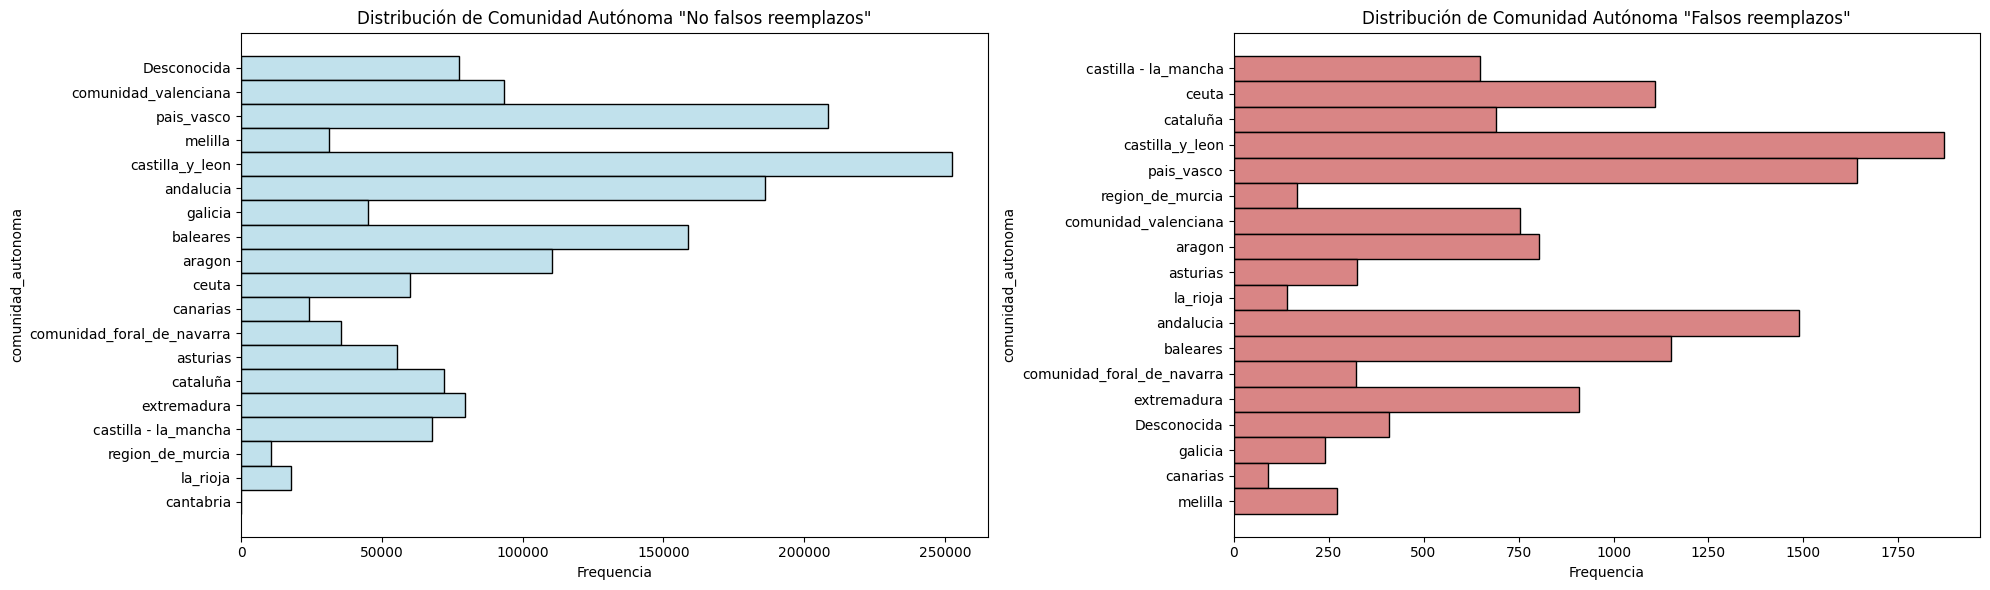

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt
var= 'comunidad_autonoma'

# Filter dataframe to only include rows where 'frfinal' is equal to 0
df0 = df[df.frfinal == 0]

# Filter dataframe to only include rows where 'frfinal' is equal to 1
df1 = df[df.frfinal == 1]

# Create a figure and a grid of subplots
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

# Create a histogram of the 'garantia_2' variable for 'frfinal' == 0
#sns.histplot(data=df0, x=var, bins=30, kde=True, color='blue', ax=axs[0])
#axs[0].set_title('Distribución de APTP "No falsos reemplazos"')
#axs[0].set_xlabel(var)
#axs[0].set_ylabel('Frequencia')
sns.histplot(data=df0, y=var, bins=30, kde=False, color='lightblue', ax=axs[0])
axs[0].set_title('Distribución de Comunidad Autónoma "No falsos reemplazos"')
axs[0].set_xlabel('Frequencia')
axs[0].set_ylabel(var)

# Create a histogram of the 'garantia_2' variable for 'frfinal' == 1
#sns.histplot(data=df1, x=var, bins=30, kde=True, color='red', ax=axs[1])
#axs[1].set_title('Distribución de APTP "Falsos reemplazos"')
#axs[1].set_xlabel(var)
#axs[1].set_ylabel('Frequencia')
sns.histplot(data=df1, y=var, bins=30, kde=False, color='indianred', ax=axs[1])
axs[1].set_title('Distribución de Comunidad Autónoma "Falsos reemplazos"')
axs[1].set_xlabel('Frequencia')
axs[1].set_ylabel(var)

# Display the figure with two subplots
plt.tight_layout()
plt.show()

## UnderSampler

In [38]:
df = df[df.aptp_c != '999 - NaN']

In [39]:
df = df.drop(['marca'], axis=1)

In [40]:
columns_to_remove = ['marca']
#columns_to_remove = ['marca','n_bm_anterior', 'garantia_2', 'desbloqueo_med', 'ratio_defensa_med']
selected_features_2 = [col for col in selected_features_2 if col not in columns_to_remove]

In [41]:
from imblearn.under_sampling import RandomUnderSampler

ros = RandomUnderSampler(sampling_strategy=0.015, random_state=43)
#ros = RandomUnderSampler(sampling_strategy=0.025, random_state=43)

In [42]:
X = df[selected_features_2]
X = X.drop('frfinal', axis=1)
y = df["frfinal"]
y.value_counts()

frfinal
0.0    1582743
1.0      13015
Name: count, dtype: int64

In [43]:
X_resampled, y_resampled = ros.fit_resample(X, y)

In [44]:
y_resampled.value_counts()

frfinal
0.0    867666
1.0     13015
Name: count, dtype: int64

In [45]:
df_Prueba = pd.concat([X_resampled, y_resampled], axis=1)

## Feature Importance

In [46]:
DF = df_Prueba[selected_features_2].copy()

In [47]:
len(DF.columns)

126

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 10412, number of negative: 694132
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.259369 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15875
[LightGBM] [Info] Number of data points in the train set: 704544, number of used features: 117
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.014778 -> initscore=-4.199703
[LightGBM] [Info] Start training from score -4.199703
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warni

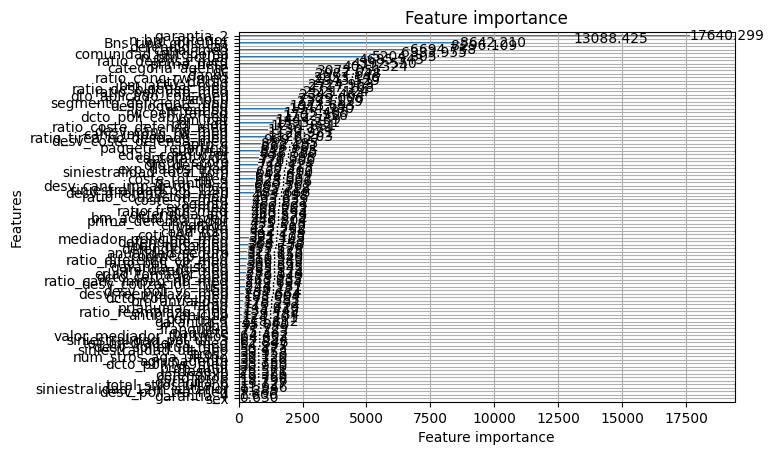

In [48]:
top_30_features, df_selected = lgbm_feature_importance(DF, "frfinal")

In [49]:
top_30_features.head(10)

,Value,Feature
124,162,garantia_2
123,162,comunidad_autonoma
122,88,ratio_defensa_med
121,88,prima_neta
120,84,segmento_deficiente_bnd
119,63,defendida_sas
118,58,ratio_desbloqueo_med
117,56,aptp_c
116,53,bm_actual_med
115,52,Bns_tipo_consulta


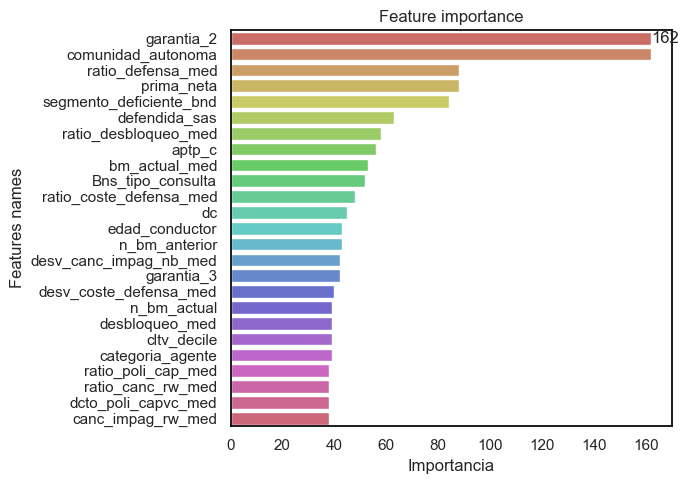

In [50]:
plot_lgb_importances(top_30_features, plot=True)

# Decision Tree

In [51]:
columns_to_select = list(set(df_selected.columns).intersection(categorical_features_2))
categorical_vars = df_Prueba[columns_to_select].columns.tolist()
print(len(categorical_vars))
categorical_vars

10


['segmento_deficiente_bnd',
 'comunidad_autonoma',
 'categoria_agente',
 'cltv_decile',
 'dc',
 'n_bm_anterior',
 'n_bm_actual',
 'Bns_tipo_consulta',
 'defendida_sas',
 'aptp_c']

In [52]:
df_encoded = label_encode_variables(df_selected, categorical_vars)
df_encoded_all = label_encode_variables(df, categorical_vars)
df_encoded.head(5)

,garantia_2,comunidad_autonoma,ratio_defensa_med,prima_neta,segmento_deficiente_bnd,defendida_sas,ratio_desbloqueo_med,aptp_c,bm_actual_med,Bns_tipo_consulta,ratio_coste_defensa_med,dc,n_bm_anterior,edad_conductor,desv_canc_impag_nb_med,garantia_3,desv_coste_defensa_med,n_bm_actual,desbloqueo_med,cltv_decile,categoria_agente,ratio_poli_cap_med,ratio_canc_rw_med,dcto_poli_capvc_med,canc_impag_rw_med,segmento_deficiente_bnd_LabelEncoded,comunidad_autonoma_LabelEncoded,categoria_agente_LabelEncoded,cltv_decile_LabelEncoded,dc_LabelEncoded,n_bm_anterior_LabelEncoded,n_bm_actual_LabelEncoded,Bns_tipo_consulta_LabelEncoded,defendida_sas_LabelEncoded,aptp_c_LabelEncoded
1778698,161,baleares,0.162228,387.15,Die.BM>=2.NM>4.Anu>2,N,3.697674,Menor 110%,7.090576,FA,114.285349,24,1,52.0,0.464480,0,0.603290,3,159.0,8.0,-Ninguno,0.232558,6.348837,26.0,75.0,14,4,0,7,3,1,3,60,1,3
4150,0,pais_vasco,0.392902,560.38,Resto,N,0.427673,Menor 170%,10.309722,NI,53.323459,28,1,50.0,0.733001,0,2.003675,1,68.0,11.0,3-Corredor FIRST,0.522013,2.396226,70.0,151.0,27,17,2,9,6,1,1,64,1,9
595026,126,baleares,0.163158,565.48,Resto,N,1.681818,Menor 100%,8.866071,NV,89.241136,24,8,56.0,0.563956,121,0.800002,7,74.0,7.0,-Ninguno,0.113636,5.818182,37.0,80.0,27,4,0,6,3,8,7,67,1,2
715262,0,pais_vasco,0.497319,332.21,Resto,N,2.025641,Menor 80%,8.819742,FA,444.107949,21,2,60.0,0.212086,0,3.981204,1,79.0,6.0,-Ninguno,0.384615,11.025641,24.0,50.0,27,17,0,5,0,2,1,60,1,18
230397,127,castilla_y_leon,0.434409,255.54,Resto,N,1.953668,Menor 140%,7.272727,FA,102.928857,26,1,62.0,0.924977,129,1.372865,1,164.0,9.0,E-Club,0.435897,6.058986,17.0,207.0,27,8,4,8,4,1,1,60,1,6


In [53]:
df_encoded_VF = df_encoded.copy()
df_encoded_VF = df_encoded_VF.drop(categorical_vars, axis=1)
df_encoded_VF.head(5)

,garantia_2,ratio_defensa_med,prima_neta,ratio_desbloqueo_med,bm_actual_med,ratio_coste_defensa_med,edad_conductor,desv_canc_impag_nb_med,garantia_3,desv_coste_defensa_med,desbloqueo_med,ratio_poli_cap_med,ratio_canc_rw_med,dcto_poli_capvc_med,canc_impag_rw_med,segmento_deficiente_bnd_LabelEncoded,comunidad_autonoma_LabelEncoded,categoria_agente_LabelEncoded,cltv_decile_LabelEncoded,dc_LabelEncoded,n_bm_anterior_LabelEncoded,n_bm_actual_LabelEncoded,Bns_tipo_consulta_LabelEncoded,defendida_sas_LabelEncoded,aptp_c_LabelEncoded
1778698,161,0.162228,387.15,3.697674,7.090576,114.285349,52.0,0.464480,0,0.603290,159.0,0.232558,6.348837,26.0,75.0,14,4,0,7,3,1,3,60,1,3
4150,0,0.392902,560.38,0.427673,10.309722,53.323459,50.0,0.733001,0,2.003675,68.0,0.522013,2.396226,70.0,151.0,27,17,2,9,6,1,1,64,1,9
595026,126,0.163158,565.48,1.681818,8.866071,89.241136,56.0,0.563956,121,0.800002,74.0,0.113636,5.818182,37.0,80.0,27,4,0,6,3,8,7,67,1,2
715262,0,0.497319,332.21,2.025641,8.819742,444.107949,60.0,0.212086,0,3.981204,79.0,0.384615,11.025641,24.0,50.0,27,17,0,5,0,2,1,60,1,18
230397,127,0.434409,255.54,1.953668,7.272727,102.928857,62.0,0.924977,129,1.372865,164.0,0.435897,6.058986,17.0,207.0,27,8,4,8,4,1,1,60,1,6


## Isolation Tree

In [68]:
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split

modelo_isof = IsolationForest(
                n_estimators  = 2000,
                max_samples   ='auto',
                contamination = 0.15,
                n_jobs        = -1,
                random_state  = 42)

modelo_isof.fit(X = df_encoded_VF)

IsolationForest(contamination=0.15, n_estimators=2000, n_jobs=-1,
                random_state=42)

In [69]:
# predict the labels (1 for inliers, -1 for outliers)
y_pred = modelo_isof.predict(df_encoded_VF)

In [70]:
y_pred

array([ 1,  1,  1, ...,  1, -1,  1])

In [71]:
# get unique values and their counts
unique, counts = np.unique(y_pred, return_counts=True)

# print the counts
print(dict(zip(unique, counts)))

{-1: 132102, 1: 748579}


## Valores Atipicos

In [72]:
print(len(df_Prueba))
print(len(y_pred))

880681
880681


In [73]:
df_Prueba['val_atipicos'] = y_pred
df_Prueba.head(5)

,prima_neta,prima_reemplazante,sinocu,siniestralidad_pol_12m,prima_defensa_adpr,siniestralidad_pol_ult_3,siniestralidad_total_tom,edad_conductor,retention,tp_c,num_stros_ultaño,num_stros_aga_ultaño,total_stros_ultaño,siniestralidad_12m_anterior,garantia_1,garantia_2,garantia_3,garantia_4,garantia_5,garantia_6,garantia_7,garantia_8,cilindrada,valorvh,plazas,antig_vehiculo,mediador_principal_med,coti_tec_med,poli_med,bm_actual_med,bm_actual_pol_med,dto_aplicado_coti_med,dcto_coti_cap_med,dcto_coti_vc_med,dcto_poli_vc_med,dcto_poli_capvc_med,prianualac_med,canc_impag_rw_med,exp_med,coste_tot_med,coste_rc_med,sini_danos_med,exp_danos_med,desbloqueo_med,defendida_med,defendible_med,ratio_defensa_med,tot_mediadores_med,ratio_cotizacion_med,ratio_reemplazo_med,ratio_bm_med,ratio_tirea_no_deseado_med,ratio_diferente_cp_med,ratio_poli_cap_med,ratio_poli_vc_med,ratio_poli_tra_med,ratio_canc_rw_med,ratio_canc_impag_nb_med,ratio_coste_defensa_med,ratio_fracc_med,ratio_desbloqueo_med,ratio_desbl_menores_med,desv_solicitud_med,desv_cotizacion_med,desv_reemplazo_med,desv_diferente_cp_med,desv_poli_vc_med,desv_poli_tra_med,desv_canc_rw_med,desv_canc_impag_nb_med,desv_coste_defensa_med,aplica,ramo,paq_reporting,agrupacm,agente,dc,sucursal,uso,categoria_agente,agrupagente,n_bm_anterior,n_bm_actual,dto_defensa,corredor_piloto,anualidad_seguro,aptp_c,rwcoeff_forced,valor_mediador_turismos,prob_anul,codmedp_bnd,prueba_piloto_bnd,super_rentables_bnd,corredores_bnd,cltv_decile,aleatorio,segmento_deficiente_bnd,captotal_vida,edad_tomador_bnd,empleados,pol_vida,bm_anualidad,bm_cat,defendible,bm_ampliado,stros2,credit_score,siniestralidad_ult_ano,defendida_sas,defendida_ant,paquete_reporting,garantia_missing,sex,asistencia,cond_tom,cond_prop,matricula,clasevh,robo,danos,franquicia,paquete,Bns_tipo_consulta,canal_med,comunidad_autonoma,frfinal,val_atipicos
1778698,387.15,0.0,0.00,330.7,0.0,125.15,42.49,52.0,0.762975,287.068272,1.0,0.0,1.0,0.0,0,161,0,0,0,0,0,0,1560,24843,7,6,700049.0,388.0,43.0,7.090576,5.674419,0.159588,256.0,93.0,3.0,26.0,2.121040e+08,75.0,141.488568,23104.50,5687.00,8.0,47.319508,159.0,67.0,413.0,0.162228,5432.0,0.354986,16.279070,5.674419,0.209302,0.076923,0.232558,0.069767,0.863636,6.348837,0.116279,114.285349,0.162791,3.697674,3.697674,2.566183,0.777703,0.632134,6.428936e-07,1.509693,2.93108,0.681736,0.464480,0.603290,0,1289,112.0,1020,700049,24,128,T 10,-Ninguno,999 - NaN,1,3,0,0,6.0,Menor 110%,999.0,N,Media,Resto,1.0,Resto,Resto,8.0,Sí,Die.BM>=2.NM>4.Anu>2,Resto,04. 46 a 60,Resto,No Pol Vida,ZZ,Z,N,999.0,Con siniestros,9,0.0,N,N,112-Basico,7,Hombre,S,S,S,4740KJT,F,999 - NaN,999 - NaN,N,1,FA,D,baleares,0.0,1
4150,560.38,0.0,0.00,0.0,0.0,248.81,44.89,50.0,0.804353,314.922337,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,1596,16145,5,15,12010.0,703.0,159.0,10.309722,6.327044,0.111868,998.0,2.0,2.0,70.0,5.211054e+04,151.0,222.914664,84645.22,24174.50,9.0,32.844593,68.0,310.0,789.0,0.392902,7510.0,0.488194,0.027668,6.327044,0.226415,0.125786,0.522013,0.040000,0.863636,2.396226,0.056604,53.323459,0.119497,0.427673,0.427673,2.566183,2.218654,1.913681,6.094911e-07,1.179672,2.93108,1.093125,0.733001,2.003675,0,1265,211.0,1020,12010,28,511,11001,3-Corredor FIRST,89-CONDICIONES ESPECIALES DEFENSA CARTERA,1,1,0,0,14.0,Menor 170%,999.0,N,Baja,Resto,1.0,Resto,Resto,11.0,No,Resto,999 - NaN,999 - NaN,Resto,999 - NaN,999 - NaN,999 - NaN,N,999.0,999 - NaN,999 - NaN,2.0,N,N,211-Todo Riesgo con Franquicia,8,Hombre,S,N,N,0266GKR,T,S,S,S,4,NI,C,pais_vasco,0.0,1
595026,565.48,0.0,913.99,0.0,0.0,-26.70,-22.91,56.0,0.762975,564.091149,0.0,0.0,0.0,0.0,0,126,121,0,128,0,0,0,1197,15350,5,6,700049.0,87.0,44.0,8.866071,7.136364,0.184643,57.0,5.0,2.0,37.0,1.515967e+04,80.0,134.372605,91776.52,11840.67,8.0,43.211772,74.0,62.0,380.0,0.163158,5784.0,0.388393,0.027668,7.136364,0.181818,0.076923,0.113636,0.045455,0.863636,5.818182,0.068182,89.241136,0.090909,1.681818,1.681818,2.566183,0.928633,1.913681,6.428936e-07,0.965186,2.93108,0.992361,0.563956,0.800002,0,1285,213.0,1020,7

In [74]:
df_Prueba.frfinal[df_Prueba.val_atipicos == -1].value_counts()

frfinal
0.0    129100
1.0      3002
Name: count, dtype: int64

### Arbol Prueba

In [75]:
df_encoded_VF['val_atipicos'] = y_pred

In [76]:
Prueba_arbol = df_encoded_VF[df_encoded_VF.val_atipicos == -1]

In [77]:
len(Prueba_arbol)

132102

Accuracy: 0.48294916922145265
AUC: 0.7203246388598428
F1 score: 0.07099625977558655
F2 score: 0.3437295791670554


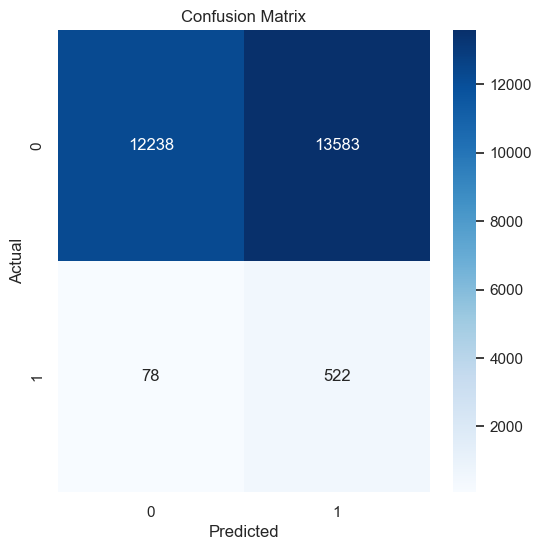

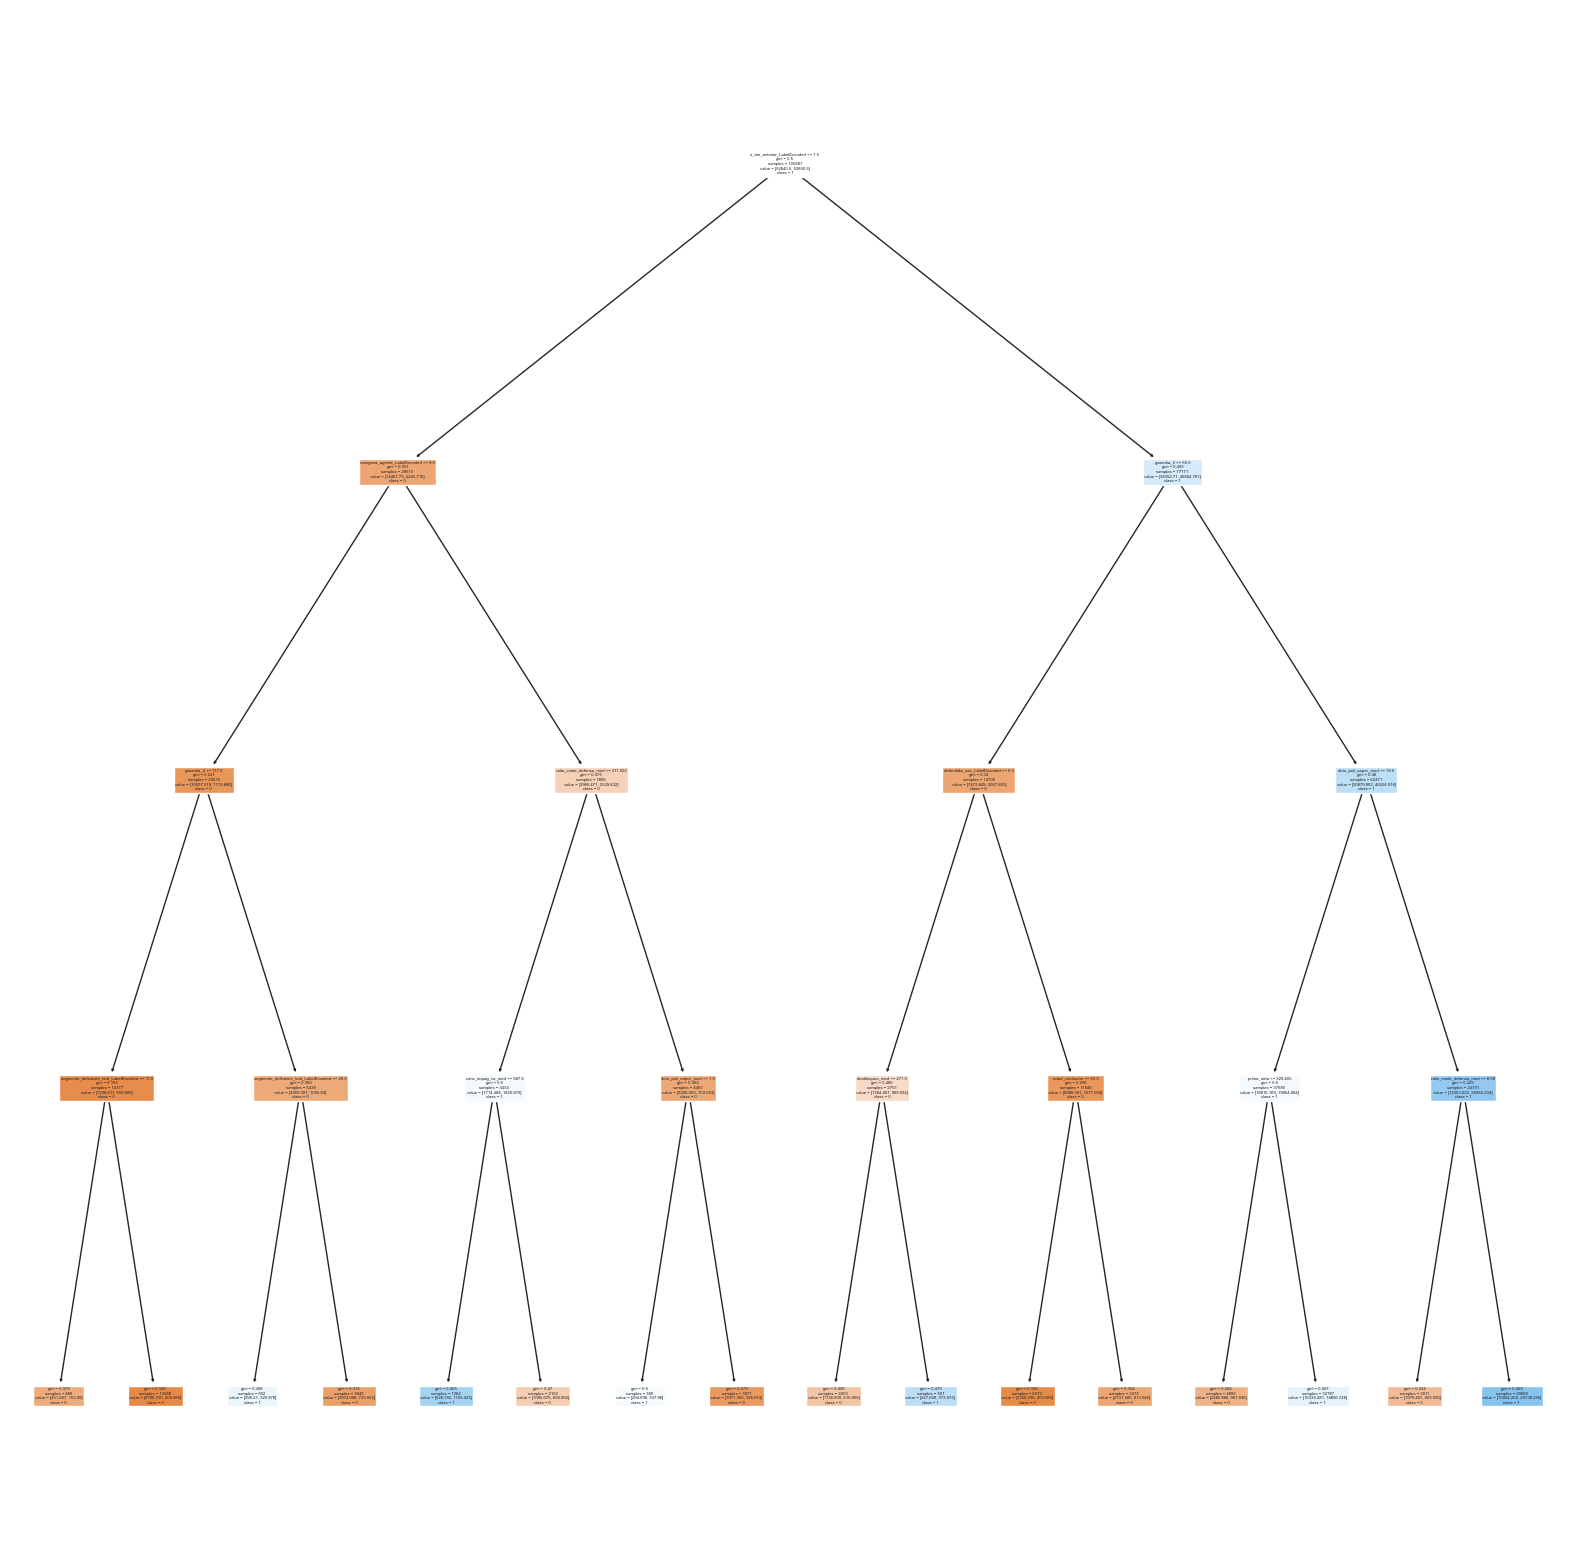

|--- n_bm_anterior_LabelEncoded <= 1.50
|   |--- categoria_agente_LabelEncoded <= 9.50
|   |   |--- garantia_2 <= 117.50
|   |   |   |--- segmento_deficiente_bnd_LabelEncoded <= 11.50
|   |   |   |   |--- class: 0.0
|   |   |   |--- segmento_deficiente_bnd_LabelEncoded >  11.50
|   |   |   |   |--- class: 0.0
|   |   |--- garantia_2 >  117.50
|   |   |   |--- segmento_deficiente_bnd_LabelEncoded <= 20.00
|   |   |   |   |--- class: 1.0
|   |   |   |--- segmento_deficiente_bnd_LabelEncoded >  20.00
|   |   |   |   |--- class: 0.0
|   |--- categoria_agente_LabelEncoded >  9.50
|   |   |--- ratio_coste_defensa_med <= 211.92
|   |   |   |--- canc_impag_rw_med <= 587.50
|   |   |   |   |--- class: 1.0
|   |   |   |--- canc_impag_rw_med >  587.50
|   |   |   |   |--- class: 0.0
|   |   |--- ratio_coste_defensa_med >  211.92
|   |   |   |--- dcto_poli_capvc_med <= 1.50
|   |   |   |   |--- class: 1.0
|   |   |   |--- dcto_poli_capvc_med >  1.50
|   |   |   |   |--- class: 0.0
|--- n_bm_anteri

DecisionTreeClassifier(class_weight='balanced', max_depth=4,
                       min_samples_leaf=500, min_weight_fraction_leaf=0,
                       random_state=123456)

In [78]:
decision_tree_model(target = 'frfinal', df_selected = Prueba_arbol, df = DF, min_samples_leaf = 500, max_depth = 4)

In [79]:
total_count = df_encoded_all['frfinal'].value_counts()

filters = [
    df_encoded_all['n_bm_anterior_LabelEncoded'] > 1.5,
    (df_encoded_all['n_bm_anterior_LabelEncoded'] > 1.5) & (df_encoded_all['garantia_2'] > 55.5),
    (df_encoded_all['n_bm_anterior_LabelEncoded'] > 1.5) & (df_encoded_all['garantia_2'] > 55.5) & (df_encoded_all['dcto_poli_capvc_med'] <= 19.5), 
    (df_encoded_all['n_bm_anterior_LabelEncoded'] > 1.5) & (df_encoded_all['garantia_2'] > 55.5) & (df_encoded_all['dcto_poli_capvc_med'] <= 19.5) & (df_encoded_all['ratio_coste_defensa_med'] > 8.08),
    (df_encoded_all['n_bm_anterior_LabelEncoded'] > 1.5) & (df_encoded_all['garantia_2'] > 55.5) & (df_encoded_all['dcto_poli_capvc_med'] <= 19.5) & (df_encoded_all['ratio_coste_defensa_med'] <= 8.08),
    (df_encoded_all['n_bm_anterior_LabelEncoded'] > 1.5) & (df_encoded_all['garantia_2'] > 55.5) & (df_encoded_all['dcto_poli_capvc_med'] > 19.5), 
    (df_encoded_all['n_bm_anterior_LabelEncoded'] > 1.5) & (df_encoded_all['garantia_2'] > 55.5) & (df_encoded_all['dcto_poli_capvc_med'] > 19.5) & (df_encoded_all['prima_neta'] > 329.4),
    (df_encoded_all['n_bm_anterior_LabelEncoded'] > 1.5) & (df_encoded_all['garantia_2'] > 55.5) & (df_encoded_all['dcto_poli_capvc_med'] > 19.5) & (df_encoded_all['prima_neta'] <= 329.4),
    
    (df_encoded_all['n_bm_anterior_LabelEncoded'] <= 1.5) & (df_encoded_all['categoria_agente_LabelEncoded'] > 9.5) & (df_encoded_all['ratio_coste_defensa_med'] <= 211.92),
    (df_encoded_all['n_bm_anterior_LabelEncoded'] <= 1.5) & (df_encoded_all['categoria_agente_LabelEncoded'] > 9.5) & (df_encoded_all['ratio_coste_defensa_med'] <= 211.92) & (df_encoded_all['canc_impag_rw_med'] <= 587.5),
]

data = {
    'FR': [],
    'No_FR': [],
    '% BBDD FR': [],
    '% BBDD No_FR': [],
    '% BBDD': []
}

for filter in filters:
    filtered_df = df_encoded_all[['frfinal']][filter]
    value_counts = filtered_df['frfinal'].value_counts()

    data['FR'].append(value_counts.get(1.0, 0))
    data['No_FR'].append(value_counts.get(0.0, 0))
    data['% BBDD FR'].append((value_counts.get(1.0, 0) / total_count.get(1.0, 0)) * 100)
    data['% BBDD No_FR'].append((value_counts.get(0.0, 0) / total_count.get(0.0, 0)) *100)
    data['% BBDD'].append((value_counts.sum() / total_count.sum()) *100)

# Create the DataFrame
FR_df = pd.DataFrame(data, index=['Rama1', 'Rama2', 'Rama3', 'Hoja3', 'Hoja4', 'Rama4', 'Hoja1', 'Hoja2', 'Rama5', 'Hoja6'])

print(FR_df)

         FR   No_FR  % BBDD FR  % BBDD No_FR     % BBDD
Rama1  9060  645066  69.611986     40.756206  40.991554
Rama2  8748  538179  67.214752     34.002930  34.273806
Rama3  4094  341281  31.456012     21.562629  21.643319
Hoja3  3806  295758  29.243181     18.686420  18.772521
Hoja4   288   45523   2.212831      2.876209   2.870799
Rama4  4654  196898  35.758740     12.440301  12.630487
Hoja1  3400  121609  26.123703      7.683433   7.833832
Hoja2  1254   75289   9.635036      4.756868   4.796655
Rama5   638   75737   4.902036      4.785174   4.786127
Hoja6   596   70254   4.579332      4.438750   4.439896


In [72]:
total_count = df_encoded_all['frfinal'].value_counts()

filters = [
    df_encoded_all['garantia_2'] > 89.5,
    (df_encoded_all['garantia_2'] > 89.5) & (df_encoded_all['n_bm_anterior_LabelEncoded'] > 2.5),
    (df_encoded_all['garantia_2'] > 89.5) & (df_encoded_all['n_bm_anterior_LabelEncoded'] > 2.5) & (df_encoded_all['ratio_defensa_med'] > 0.117), 
    (df_encoded_all['garantia_2'] > 89.5) & (df_encoded_all['n_bm_anterior_LabelEncoded'] > 2.5) & (df_encoded_all['ratio_defensa_med'] > 0.117) & (df_encoded_all['ratio_desbloqueo_med'] > 1.172),
    (df_encoded_all['garantia_2'] > 89.5) & (df_encoded_all['n_bm_anterior_LabelEncoded'] > 2.5) & (df_encoded_all['ratio_defensa_med'] > 0.117) & (df_encoded_all['ratio_desbloqueo_med'] <= 1.172),
    (df_encoded_all['garantia_2'] > 89.5) & (df_encoded_all['n_bm_anterior_LabelEncoded'] > 2.5) & (df_encoded_all['ratio_defensa_med'] <= 0.117), 
    (df_encoded_all['garantia_2'] > 89.5) & (df_encoded_all['n_bm_anterior_LabelEncoded'] > 2.5) & (df_encoded_all['ratio_defensa_med'] <= 0.117) & (df_encoded_all['canc_impag_rw_med'] <= 212.0),
    (df_encoded_all['garantia_2'] > 89.5) & (df_encoded_all['n_bm_anterior_LabelEncoded'] > 2.5) & (df_encoded_all['ratio_defensa_med'] <= 0.117) & (df_encoded_all['canc_impag_rw_med'] > 212.0),

    (df_encoded_all['garantia_2'] > 89.5) & (df_encoded_all['n_bm_anterior_LabelEncoded'] <= 2.5) & (df_encoded_all['garantia_2'] > 167.5),
    (df_encoded_all['garantia_2'] > 89.5) & (df_encoded_all['n_bm_anterior_LabelEncoded'] <= 2.5) & (df_encoded_all['garantia_2'] > 167.5) & (df_encoded_all['defendida_sas_LabelEncoded'] <= 1.5),

    
    (df_encoded_all['garantia_2'] <= 89.5) & (df_encoded_all['garantia_2'] > 56.5) & (df_encoded_all['n_bm_actual_LabelEncoded'] > 3.5),
    (df_encoded_all['garantia_2'] <= 89.5) & (df_encoded_all['garantia_2'] > 56.5) & (df_encoded_all['n_bm_actual_LabelEncoded'] > 3.5) & (df_encoded_all['ratio_desbloqueo_med'] > 0.43)
]

data = {
    'FR': [],
    'No_FR': [],
    '% BBDD FR': [],
    '% BBDD No_FR': [],
    '% BBDD': []
}

for filter in filters:
    filtered_df = df_encoded_all[['frfinal']][filter]
    value_counts = filtered_df['frfinal'].value_counts()

    data['FR'].append(value_counts.get(1.0, 0))
    data['No_FR'].append(value_counts.get(0.0, 0))
    data['% BBDD FR'].append((value_counts.get(1.0, 0) / total_count.get(1.0, 0)) * 100)
    data['% BBDD No_FR'].append((value_counts.get(0.0, 0) / total_count.get(0.0, 0)) *100)
    data['% BBDD'].append((value_counts.sum() / total_count.sum()) *100)

# Create the DataFrame
FR_df = pd.DataFrame(data, index=['Rama1', 'Rama2', 'Rama3', 'Hoja1', 'Hoja2', 'Rama4', 'Hoja4', 'Hoja3', 'Rama5', 'Hoja6', 'Rama6', 'Hoja9'])

print(FR_df)

          FR    No_FR  % BBDD FR  % BBDD No_FR     % BBDD
Rama1  11092  1042823  85.185470     65.881243  66.038747
Rama2   7271   388033  55.840565     24.514320  24.769911
Rama3   6850   334336  52.607327     21.121965  21.378855
Hoja1   5712   232387  43.867598     14.681249  14.919381
Hoja2   1138   101949   8.739728      6.440716   6.459474
Rama4    421    53697   3.233239      3.392354   3.391056
Hoja4    382    42530   2.933722      2.686869   2.688884
Hoja3     39    11167   0.299516      0.705485   0.702173
Rama5   1060    76128   8.140696      4.809452   4.836632
Hoja6    991    56347   7.610783      3.559770   3.592823
Rama6    390    37730   2.995162      2.383625   2.388615
Hoja9    382    33432   2.933722      2.112095   2.118799


## Filtros Buenos

In [94]:
total_count = df_encoded_all['frfinal'].value_counts()

filters = [
    df_encoded_all['garantia_2'] > 97.5,
    (df_encoded_all['garantia_2'] > 97.5) & (df_encoded_all['n_bm_anterior_LabelEncoded'] > 1.5),
    (df_encoded_all['garantia_2'] > 97.5) & (df_encoded_all['n_bm_anterior_LabelEncoded'] > 1.5) & (df_encoded_all['dcto_poli_capvc_med'] > 19.5), 
    (df_encoded_all['garantia_2'] > 97.5) & (df_encoded_all['n_bm_anterior_LabelEncoded'] > 1.5) & (df_encoded_all['dcto_poli_capvc_med'] > 19.5) & (df_encoded_all['ratio_coste_defensa_med'] > 8.08),
    (df_encoded_all['garantia_2'] > 97.5) & (df_encoded_all['n_bm_anterior_LabelEncoded'] > 1.5) & (df_encoded_all['dcto_poli_capvc_med'] > 19.5) & (df_encoded_all['ratio_coste_defensa_med'] <= 8.08),
    (df_encoded_all['garantia_2'] > 97.5) & (df_encoded_all['n_bm_anterior_LabelEncoded'] > 1.5) & (df_encoded_all['dcto_poli_capvc_med'] <= 19.5), 
    (df_encoded_all['garantia_2'] > 97.5) & (df_encoded_all['n_bm_anterior_LabelEncoded'] > 1.5) & (df_encoded_all['dcto_poli_capvc_med'] <= 19.5) & (df_encoded_all['ratio_defensa_med'] > 0.11),
    (df_encoded_all['garantia_2'] > 97.5) & (df_encoded_all['n_bm_anterior_LabelEncoded'] > 1.5) & (df_encoded_all['dcto_poli_capvc_med'] <= 19.5) & (df_encoded_all['ratio_defensa_med'] <= 0.11),
    (df_encoded_all['garantia_2'] > 97.5) & (df_encoded_all['n_bm_anterior_LabelEncoded'] <= 1.5) & (df_encoded_all['categoria_agente_LabelEncoded'] > 9.5) & (df_encoded_all['defendida_sas_LabelEncoded'] <= 1.5),
    (df_encoded_all['garantia_2'] <= 97.5) & (df_encoded_all['n_bm_actual_LabelEncoded'] > 6.5) & (df_encoded_all['garantia_2'] > 55.5) & (df_encoded_all['ratio_desbloqueo_med'] > 0.44)
    #(df_encoded_all['n_bm_actual_LabelEncoded'] >= 1.5) & (df_encoded_all['garantia_2'] <= 58.5) & (df_encoded_all['ratio_poli_cap_med'] >= 0.43) & (df_encoded_all['cltv_decile_LabelEncoded'] >= 4.5),  
    #(df_encoded_all['n_bm_actual_LabelEncoded'] >= 1.5) & (df_encoded_all['garantia_2'] >= 58.5) & (df_encoded_all['defendida_sas_LabelEncoded'] <= 0.5)
]

data = {
    'FR': [],
    'No_FR': [],
    '% BBDD FR': [],
    '% BBDD No_FR': [],
    '% BBDD': []
}

for filter in filters:
    filtered_df = df_encoded_all[['frfinal']][filter]
    value_counts = filtered_df['frfinal'].value_counts()

    data['FR'].append(value_counts.get(1.0, 0))
    data['No_FR'].append(value_counts.get(0.0, 0))
    data['% BBDD FR'].append((value_counts.get(1.0, 0) / total_count.get(1.0, 0)) * 100)
    data['% BBDD No_FR'].append((value_counts.get(0.0, 0) / total_count.get(0.0, 0)) *100)
    data['% BBDD'].append((value_counts.sum() / total_count.sum()) *100)

# Create the DataFrame
FR_df = pd.DataFrame(data, index=['Rama1', 'Rama2', 'Rama3', 'Hoja1', 'Hoja2', 'Rama4', 'Hoja3', 'Hoja4', 'Hoja6', 'Hoja9'])

print(FR_df)

          FR   No_FR  % BBDD FR  % BBDD No_FR     % BBDD
Rama1  10671  942987  81.952231     59.574018  59.756602
Rama2   8028  459772  61.654251     29.046493  29.312540
Rama3   4217  166335  32.386145     10.508357  10.686858
Hoja1   4136  152602  31.764073      9.640763   9.821267
Hoja2     81   13733   0.622072      0.867594   0.865591
Rama4   3811  293437  29.268105     18.538136  18.625682
Hoja3   3504  248113  26.910376     15.674753  15.766425
Hoja4    307   45324   2.357730      2.863383   2.859257
Hoja6    517   46726   3.970509      2.951955   2.960266
Hoja9    457   30672   3.509715      1.937730   1.950556


Accuracy: 0.6273408239700374
AUC: 0.7357916333235154
F1 score: 0.07480980557903635
F2 score: 0.41856185184606703


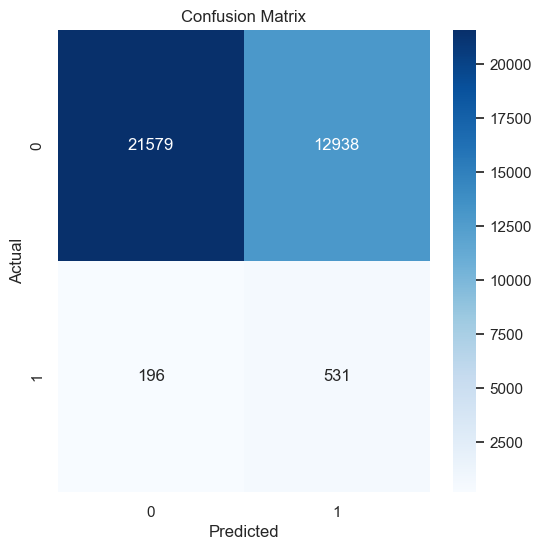

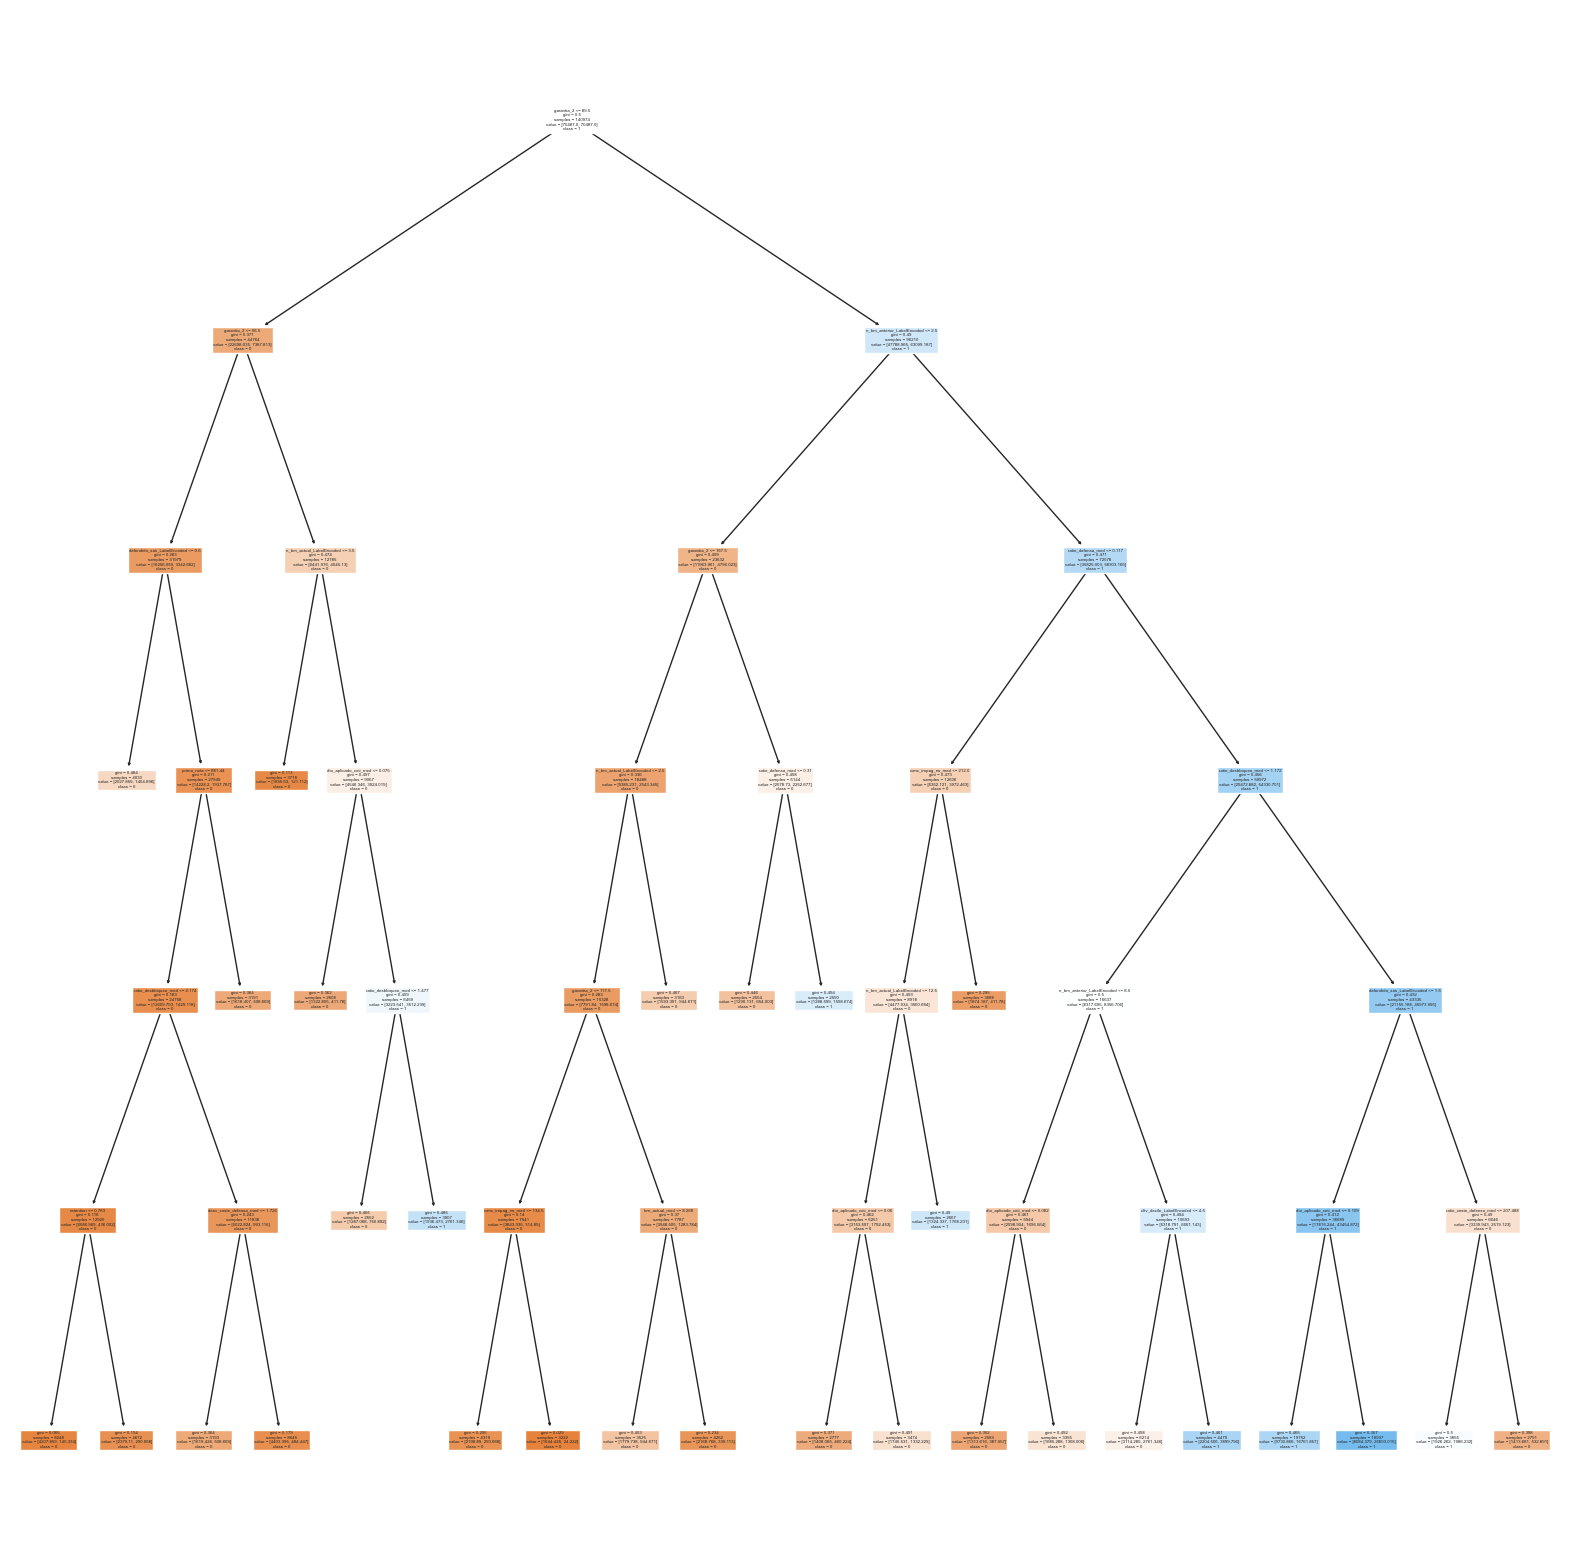

|--- garantia_2 <= 89.50
|   |--- garantia_2 <= 56.50
|   |   |--- defendida_sas_LabelEncoded <= 0.50
|   |   |   |--- class: 0.0
|   |   |--- defendida_sas_LabelEncoded >  0.50
|   |   |   |--- prima_neta <= 881.44
|   |   |   |   |--- ratio_desbloqueo_med <= 2.17
|   |   |   |   |   |--- retention <= 0.76
|   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |--- retention >  0.76
|   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |--- ratio_desbloqueo_med >  2.17
|   |   |   |   |   |--- desv_coste_defensa_med <= 1.73
|   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |--- desv_coste_defensa_med >  1.73
|   |   |   |   |   |   |--- class: 0.0
|   |   |   |--- prima_neta >  881.44
|   |   |   |   |--- class: 0.0
|   |--- garantia_2 >  56.50
|   |   |--- n_bm_actual_LabelEncoded <= 3.50
|   |   |   |--- class: 0.0
|   |   |--- n_bm_actual_LabelEncoded >  3.50
|   |   |   |--- dto_aplicado_coti_med <= 0.07
|   |   |   |   |--- class: 0.0
|   |   |   |--- dto_aplicad

['__abstractmethods__',
 '__annotations__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__sklearn_clone__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_build_request_for_signature',
 '_check_feature_names',
 '_check_n_features',
 '_compute_missing_values_in_feature_mask',
 '_estimator_type',
 '_fit',
 '_get_default_requests',
 '_get_metadata_request',
 '_get_param_names',
 '_get_tags',
 '_more_tags',
 '_parameter_constraints',
 '_prune_tree',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_support_missing_values',
 '_validate_X_predict',
 '_validate_data',
 '_validate_params',
 'apply',
 'ccp_alpha',
 'class_weight',
 'classes_',
 'cost_comple

In [159]:
dir(decision_tree_model(target = 'frfinal', df_selected = Prueba_arbol, df = DF, min_samples_leaf = 2550, max_depth = 6))

In [81]:
total_count = df_encoded_all['frfinal'].value_counts()

filters = [
    df_encoded_all['n_bm_actual_LabelEncoded'] >= 1.5,
    (df_encoded_all['n_bm_actual_LabelEncoded'] >= 1.5) & (df_encoded_all['garantia_missing_LabelEncoded'] <= 2.5),
    (df_encoded_all['n_bm_actual_LabelEncoded'] >= 1.5) & (df_encoded_all['garantia_missing_LabelEncoded'] <= 2.5) & (df_encoded_all['ratio_poli_cap_med'] >= 0.43),
    (df_encoded_all['n_bm_actual_LabelEncoded'] >= 1.5) & (df_encoded_all['garantia_missing_LabelEncoded'] <= 2.5) & (df_encoded_all['ratio_poli_cap_med'] >= 0.43) & (df_encoded_all['cltv_decile_LabelEncoded'] >= 4.5),
    (df_encoded_all['n_bm_actual_LabelEncoded'] >= 1.5) & (df_encoded_all['garantia_missing_LabelEncoded'] <= 2.5) & (df_encoded_all['ratio_poli_cap_med'] >= 0.43) & (df_encoded_all['cltv_decile_LabelEncoded'] <= 4.5),  
    (df_encoded_all['n_bm_actual_LabelEncoded'] >= 1.5) & (df_encoded_all['garantia_missing_LabelEncoded'] <= 2.5) & (df_encoded_all['ratio_poli_cap_med'] <= 0.43) & (df_encoded_all['ratio_desbloqueo_med'] <= 0.62),
    (df_encoded_all['n_bm_actual_LabelEncoded'] >= 1.5) & (df_encoded_all['garantia_missing_LabelEncoded'] >= 2.5) & (df_encoded_all['defendida_sas_LabelEncoded'] <= 0.5) & (df_encoded_all['canc_impag_rw_med'] <= 25.5),
    (df_encoded_all['n_bm_actual_LabelEncoded'] <= 1.5) & (df_encoded_all['garantia_3'] >= 150.5) & (df_encoded_all['bm_actual_med'] <= 6.74),
    (df_encoded_all['n_bm_actual_LabelEncoded'] <= 1.5) & (df_encoded_all['garantia_3'] <= 150.5) & (df_encoded_all['prima_neta'] <= 1294.66),

    #(df_encoded_all['garantia_2'] >= 55.5) & (df_encoded_all['n_bm_anterior_LabelEncoded'] >= 1.5),
    #(df_encoded_all['garantia_2'] >= 55.5) & (df_encoded_all['n_bm_anterior_LabelEncoded'] >= 1.5) & (df_encoded_all['ratio_defensa_med'] >= 0.1),
    #(df_encoded_all['garantia_2'] >= 55.5) & (df_encoded_all['n_bm_anterior_LabelEncoded'] >= 1.5) & (df_encoded_all['ratio_defensa_med'] >= 0.1) & (df_encoded_all['desbloqueo_med'] >= 76.5),
    #(df_encoded_all['garantia_2'] >= 55.5) & (df_encoded_all['n_bm_anterior_LabelEncoded'] >= 1.5) & (df_encoded_all['ratio_defensa_med'] >= 0.1) & (df_encoded_all['desbloqueo_med'] <= 76.5),
    #(df_encoded_all['garantia_2'] >= 55.5) & (df_encoded_all['n_bm_anterior_LabelEncoded'] >= 1.5) & (df_encoded_all['ratio_defensa_med'] <= 0.1) & (df_encoded_all['categoria_agente_LabelEncoded'] >= 9.5)

]

data = {
    'FR': [],
    'No_FR': [],
    '% BBDD FR': [],
    '% BBDD No_FR': [],
    '% BBDD': []
}

for filter in filters:
    filtered_df = df_encoded_all[['frfinal']][filter]
    value_counts = filtered_df['frfinal'].value_counts()

    data['FR'].append(value_counts.get(1.0, 0))
    data['No_FR'].append(value_counts.get(0.0, 0))
    data['% BBDD FR'].append((value_counts.get(1.0, 0) / total_count.get(1.0, 0)) * 100)
    data['% BBDD No_FR'].append((value_counts.get(0.0, 0) / total_count.get(0.0, 0)) *100)
    data['% BBDD'].append((value_counts.sum() / total_count.sum()) *100)

# Create the DataFrame
FR_df = pd.DataFrame(data, index=['Rama1', 'Rama2', 'Rama3', 'Hoja5', 'Hoja6', 'Hoja8', 'Hoja3', 'Rama4', 'Rama5'])

print(FR_df)

         FR   No_FR  % BBDD FR  % BBDD No_FR     % BBDD
Rama1  8530  587840  65.429163     37.056065  37.287341
Rama2  8296  506517  63.634272     31.929652  32.188084
Rama3  3525  314955  27.038429     19.854030  19.912592
Hoja5  2219  150046  17.020787      9.458551   9.520192
Hoja6  1306  164909  10.017642     10.395479  10.392400
Hoja8   153   22109   1.173583      1.393700   1.391906
Hoja3    17    2343   0.130398      0.147697   0.147556
Rama4   203   16907   1.557107      1.065778   1.069783
Rama5  3515  891058  26.961724     56.170222  55.932137


In [ ]:
## Label 

In [75]:
df_encoded_all['n_bm_actual'][df_encoded_all.n_bm_actual_LabelEncoded <= 2.5].value_counts()

n_bm_actual
1    1003019
2     117965
0          1
Name: count, dtype: int64

In [91]:
df_encoded_all['n_bm_actual'].value_counts()

n_bm_actual
1     1003019
2      117965
3       97438
4       67049
5       52108
6       40477
7       35761
8       30665
9       27928
10      23512
13      22492
14      20804
11      19575
12      19163
15       6678
16       5093
17       3072
18       3044
19       1145
20        976
22        560
21        479
24        230
23        156
0           1
Name: count, dtype: int64

In [ ]:
## Check

In [112]:
value_to_check = 'T 10'

columns_with_value = X.apply(lambda column: value_to_check in column.values)

try:
    columns_with_value_true = columns_with_value[columns_with_value].index.tolist()
except ValueError:
    columns_with_value_true = columns_with_value[columns_with_value].apply(
        lambda x: np.nan if isinstance(x, str) and x != value_to_check else x
    ).dropna(how='all').index.tolist()

print(columns_with_value_true)

['uso']
